In [164]:
import os
import pandas as pd
import numpy as np
import chardet
import numpy as np
import scipy.stats
import warnings
from scipy.constants import R
from scipy import integrate
from scipy.integrate import quad, cumtrapz
from tqdm.auto import tqdm
import plotly.graph_objects as go
import re
import seaborn as sns
from sklearn.metrics import r2_score 

# Указываем строку, с которой начинается чтение данных 
SRART_ROW = 36  # Нумерация с нуля, поэтому 36 строка в файле - это индекс 35

# Указываем название элемента, с  работатьработаткоторым хотим 
ELEMENT = 'Dy'

# Какие скорости нагрева представленны в экспериментальных данных и в каком порядке
# в градус/минута
heating_rates = ['3', '10', '5']

# Указываем названия колонок
column_names = ['temperature'] + heating_rates

# Указываем путь к папке
folder_path = "TGA"

# Получаем все файлы в указанной папке
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Проверяем, есть ли файлы в списке
if not file_list:
    raise Exception("No files found in the specified directory.")
    
# Выбираем первый файл из списка
tga_file = [file for file in file_list if file.startswith(ELEMENT)]


# Определяем кодировку файла
with open(os.path.join(folder_path, tga_file[0]), 'rb') as f:
    result = chardet.detect(f.read())
file_encoding = result['encoding']

# Считывание данных из CSV файла
df = pd.read_csv(
    os.path.join(folder_path, tga_file[0]),
    skiprows=SRART_ROW,
    names=column_names,
    delimiter=';',
    decimal=',',
    encoding=file_encoding,
    dtype=str  # Прочитать все данные как строки
)

# Замена запятых на точки и преобразование в числа
df = df.apply(lambda x: pd.to_numeric(x.str.replace(',', '.'), errors='coerce'))

# Удаление строк с NaN значениями
df.dropna(inplace=True)

# Устанавливаем колонку 'temperature' в качестве индекса
df.set_index('temperature', inplace=True)

# Сортировка столбцов DataFrame по heating_rates
heating_rates.sort(key=int)  # сортировка элементов списка как целых чисел
df = df[heating_rates]  # переупорядочивание столбцов DataFrame

# Вывод первых пяти строк данных
df.head()

,3,5,10
temperature,,,
31.63192,99.99894,100.07588,99.96317
32.58683,99.99902,100.04476,99.97090
33.54175,100.00064,100.03758,99.97650
34.49666,100.00060,100.03165,99.98113
35.45158,99.99498,100.03084,99.97782


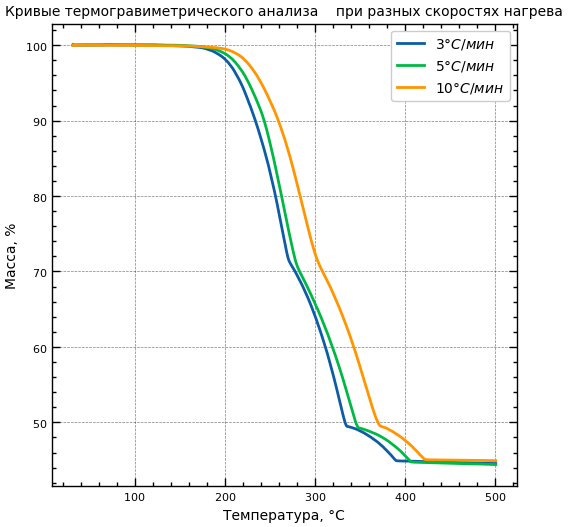

In [165]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

# задаём константы для графиков
BIG_SIZE = 12
MEDIUM_SIZE = 10
SMALL_SIZE = 8

# Создаём фигуру 
fig, axes = plt.subplots(figsize=(6, 6))

axes.plot(df.index, df['3'], label=r'$3°C/мин$')
axes.plot(df.index, df['5'], label=r'$5°C/мин$')
axes.plot(df.index, df['10'], label=r'$10°C/мин$')

# Добавляем подписи на оси
axes.set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
axes.set_ylabel('Масса, %', fontsize=MEDIUM_SIZE)
# Добавляем заголовок
axes.set_title('Кривые термогравиметрического анализа\
    при разных скоростях нагрева', 
               fontsize=MEDIUM_SIZE)
# Настраиваем размер легенды и подписей осей
axes.legend(loc='upper right', fontsize=MEDIUM_SIZE)
axes.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

plt.show()

Кинетику твердофазных реакций можно изучать с помощью термических аналитических методов путем измерения свойств образца при нагреве или при постоянной температуре. Если реакция связана с потерей массы, то масса отслеживается на протяжении реакции, и кинетика обычно изучается с помощью термогравиметрии (ТГА). Тепловой эффект (выделяющийся или поглощаемый) - это еще одно измеряемое свойство, которое используется для кинетической оценки с использованием дифференциальной сканирующей калориметрии (ДСК) или дифференциального термического анализа (ДТА). Данные о потере массы или потоке тепла преобразуются в нормализованную форму, называемую степенью превращения ($\alpha$). Степень превращения варьирует от 0 до 1 и является мерой прогресса реакции в зависимости от времени или температуры.

Для изотермического термогравиметрического анализа доля превращения в любой момент времени определяется следующим образом:

$$ \alpha = \frac{{m_0 - m_t}}{{m_0 - m_{\infty}}} \tag{1}$$

где:
$ m_0 $ - начальная масса образца,
 $ m_t $ - масса образца в момент времени $ t $, 
 $ m_{\infty} $ - конечная масса образца.


In [166]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['3'], name=r'$3°C/мин$'))
fig.add_trace(go.Scatter(x=df.index, y=df['5'], name=r'$5°C/мин$'))
fig.add_trace(go.Scatter(x=df.index, y=df['10'], name=r'$10°C/мин$'))

fig.update_layout(
xaxis=dict(title='Температура, °С'),
yaxis=dict(title='Масса, %'),
title=dict(text='Кривые термогравиметрического анализа\
    при разных скоростях нагрева')
)

fig.update_layout(
legend=dict(
x=1,
y=1,
traceorder="normal",
font=dict(size=10)
),
xaxis_tickfont=dict(size=8),
yaxis_tickfont=dict(size=8)
)

fig.show()

<AxesSubplot: >

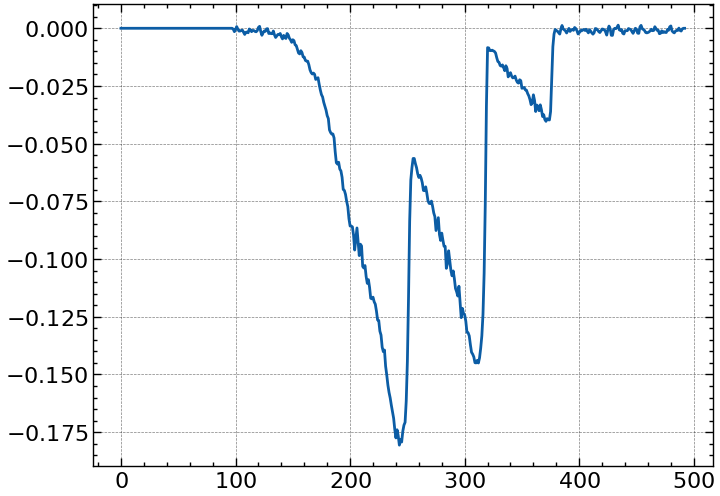

In [167]:
# Указываем путь к папке
folder_path = "_DSC"

# Получаем все файлы в указанной папке
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Проверяем, есть ли файлы в списке
if not file_list:
    raise Exception("No files found in the specified directory.")

_df = pd.read_csv(folder_path + '/' + f'{heating_rates[0]}' + '.csv', sep=';')
_df['DTG'].plot()

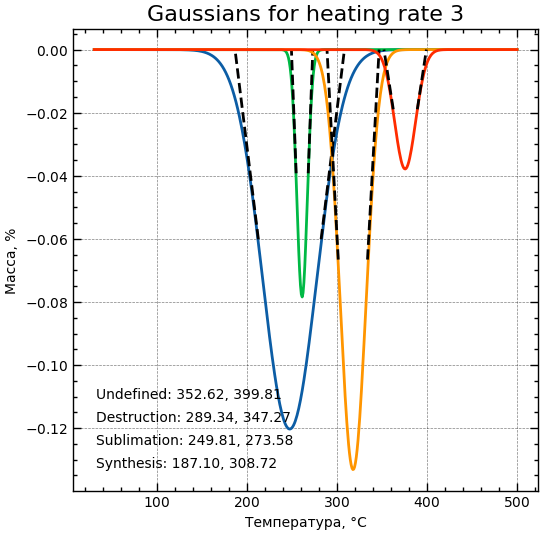

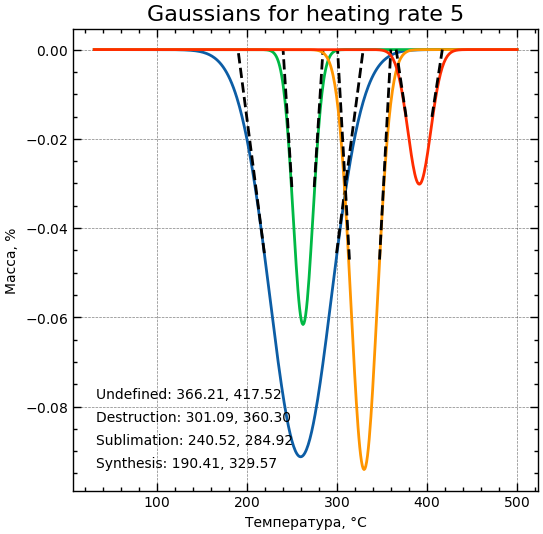

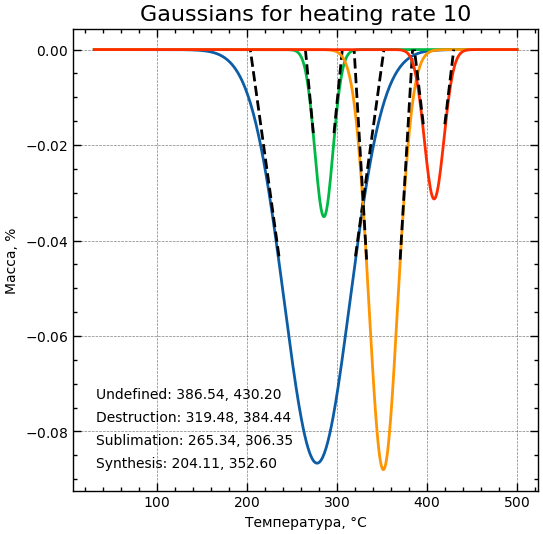

,Area_Synthesis_rate_3,Area_Sublimation_rate_3,Area_Destruction_rate_3,Area_Undefined_rate_3,Area_Synthesis_rate_5,Area_Sublimation_rate_5,Area_Destruction_rate_5,Area_Undefined_rate_5,Area_Synthesis_rate_10,Area_Sublimation_rate_10,Area_Destruction_rate_10,Area_Undefined_rate_10
Total area,-8.654062,-1.085253,-4.557605,-1.048201,-7.504356,-1.614814,-3.285829,-0.914141,-7.614638,-0.844835,-3.366092,-0.808177


In [168]:
# Задаем названия столбцов для гауссианов (этапы реакции)
gaussian_cols = ['Synthesis', 'Sublimation', 'Destruction', 'Undefined']

# Создаем пустой DataFrame для хранения результатов по каждому этапу для каждой скорости нагрева
reactions_df = pd.DataFrame(columns=[f'{col}_rate_{rate}' for rate in heating_rates for col in gaussian_cols])

# Создаем DataFrame для хранения общих площадей под кривыми каждого этапа для каждой скорости нагрева
area_df = pd.DataFrame(columns=[f'Area_{col}_rate_{rate}' for rate in heating_rates for col in gaussian_cols])

# Проходим по всем скоростям нагрева
for rate in heating_rates:
    # Читаем данные из файла .csv для текущей скорости нагрева
    _df = pd.read_csv(folder_path + '/' + f'{rate}' + '.csv', sep=';')

    # Создаем новую фигуру для визуализации результатов
    fig, ax = plt.subplots(figsize=(6, 6))

    # Проходим по всем этапам
    for col in gaussian_cols:
        # Рисуем график зависимости параметра этапа от температуры
        ax.plot(_df['T'], _df[col])

        # Вычисляем половину минимального значения параметра этапа
        half_height = _df[col].min() / 2.0

        # Находим индексы, соответствующие половине высоты
        left_index = np.where(_df[col] <= half_height)[0][0]
        right_index = np.where(_df[col] <= half_height)[0][-1]

        # Вычисляем угловые коэффициенты для левой и правой линий
        left_slope = (_df[col].iloc[left_index] - _df[col].iloc[left_index-1]) / (_df['T'].iloc[left_index] - _df['T'].iloc[left_index-1])
        right_slope = (_df[col].iloc[right_index] - _df[col].iloc[right_index+1]) / (_df['T'].iloc[right_index] - _df['T'].iloc[right_index+1])

        # Вычисляем точки пересечения линий с осью температур
        left_intercept = _df[col].iloc[left_index] - left_slope * _df['T'].iloc[left_index]
        right_intercept = _df[col].iloc[right_index] - right_slope * _df['T'].iloc[right_index]

        left_x_intercept = -left_intercept / left_slope
        right_x_intercept = -right_intercept / right_slope

        # Рисуем эти линии на графике
        ax.plot([_df['T'].iloc[left_index], left_x_intercept], [half_height, 0], 'k--')
        ax.plot([_df['T'].iloc[right_index], right_x_intercept], [half_height, 0], 'k--')

        # Записываем полученные результаты в DataFrame
        reactions_df.loc['FWHM Temp (lower)', f'{col}_rate_{rate}'] = _df['T'].iloc[left_index]
        reactions_df.loc['FWHM Temp (upper)', f'{col}_rate_{rate}'] = _df['T'].iloc[right_index]
        reactions_df.loc['start_t', f'{col}_rate_{rate}'] = left_x_intercept
        reactions_df.loc['end_t', f'{col}_rate_{rate}'] = right_x_intercept

        # Вычисляем общую площадь под кривой
        total_area = np.trapz(_df[col][(left_x_intercept <= _df['T']) & (_df['T'] <= right_x_intercept)], x=_df['T'][(left_x_intercept <= _df['T']) & (_df['T'] <= right_x_intercept)])

        # Записываем общую площадь в DataFrame
        area_df.loc['Total area', f'Area_{col}_rate_{rate}'] = total_area

        # Вычисляем относительную площадь для каждой температуры в заданном диапазоне и записываем результат в DataFrame
        for t in _df['T']:
            if left_x_intercept <= t <= right_x_intercept:
                current_area = np.trapz(_df[col][(left_x_intercept <= _df['T']) & (_df['T'] <= t)], x=_df['T'][(left_x_intercept <= _df['T']) & (_df['T'] <= t)])
                relative_area = current_area / total_area
                reactions_df.loc[t, f'conversion_{col}_{rate}'] = relative_area

    # Задаем надписи на графике
    ax.set_xlabel('Температура, °С', fontsize=MEDIUM_SIZE)
    ax.set_ylabel('Масса, %', color='black', fontsize=MEDIUM_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE, colors='black')

    # Добавляем текстовые метки для каждого этапа на графике
    for col in gaussian_cols:
        ax.text(0.05, 0.05 + gaussian_cols.index(col)*0.05, f'{col}: {reactions_df.loc["start_t", f"{col}_rate_{rate}"]:.2f}, {reactions_df.loc["end_t", f"{col}_rate_{rate}"]:.2f}',
                transform=ax.transAxes, fontsize=MEDIUM_SIZE)

    # Устанавливаем название графика и включаем сетку
    plt.title(f'Gaussians for heating rate {rate}')
    plt.grid(True)
    plt.show()

# Выводим содержимое на экран
reactions_df
area_df


Находим температуры при которых заканчиваются одни реакции и начинаются другие

Разделяем поле температур на области реакций

Находим степень конверсии для каждой реакции в каждом значении температуры

$$ Прямой~дифференциальный~метод$$
Этот метод использует скорость нагрева, обычно линейную ($\beta$), для повышения температуры. Линейная программа нагрева следует формуле:

$$ T = T_0 + \beta t \tag{2}$$

где $T_0$ - начальная температура, $\beta$ - линейная скорость нагрева (К/мин), и $T$ - температура в момент времени $t$. 

Следующее соотношение можно определить для неизотермических экспериментов:

$$ \frac{{d\alpha}}{{dT}} = \frac{{d\alpha}}{{dt}} \cdot \frac{{dt}}{{dT}} \tag{3}$$

где $\frac{{d\alpha}}{{dT}}$ - неизотермическая скорость реакции; $\frac{{d\alpha}}{{dt}}$ - изотермическая скорость реакции, а $\frac{{dt}}{{dT}}$ - скорость нагрева ($\beta$). 

Дифференциальный закон скорости для реакции первого порядка может быть записан в виде:$$ Скорость~реакции~=~\frac{d[A]}{dt}=-k[A]\tag{4}$$ 
Здесь скорость реакции (изменение концентрации $[A]$ в единицу времени) пропорциональна концентрации реагента $[A]$. Отрицательный знак указывает на то, что концентрация $[A]$ с течением времени уменьшается.


Переформулировав уравнение (4), заменим концентрацию реагента $[A]$ на степень превращения $\alpha$: $$ Скорость~реакции~=~\frac{d\alpha}{dt} = k\left(1 - \alpha\right) \tag{5}$$

Обобщим уравнение (5), введя функцию $f(\alpha)$, которая отражает специфический характер реакции.$$\frac{d\alpha}{dt} = kf(\alpha)\tag{6}$$ 

Уравнение Аррениуса, которое описывает температурную зависимость константы скорости реакции выглядит следующим образом:$$k = A e^{-\frac{E_a}{RT}} \tag{7}$$
Путем подстановки уравнения Аррениуса (7) в обобщенный дифференциальный закон скорости (6) получаем:$$\frac{d\alpha}{dt} = A e^{-\frac{E_a}{RT}}f(\alpha) \tag{8}$$
Подставляя уравнение (8) в уравнение (3), получим дифференциальную форму неизотермического закона скорости:

$$ \frac{{d\alpha}}{{dT}} = \frac{A}{\beta}  e^{-\frac{{E_a}}{{RT}}}  f(\alpha) \tag{9}$$
Откуда: $$\ln\left(\frac{{da}}{{dT}}\cdot\frac{{1}}{{f(a)}}\right) = \ln \frac{{A}}{{\beta}} - \frac{{E_a}}{{RT}} \tag{10}$$

Построение графика левой части (включая модель $f(\alpha)$) относительно $\frac{1}{T}$ позволяет получить энергию активации ($E_a$) и предэкспоненциальный множитель ($A$) из наклона и пересечения с осью $y$ соответственно. Обычно выбирается модель, которая обеспечивает наилучшую линейную аппроксимацию.


In [169]:
# Загружаем данные по кинетическим моделям
models_df = pd.read_csv('nucleation_models.csv')
# models_df.loc[models_df['Model'] == 'Zero-order (F0/R1)', 'Differential Form'] = 'np.full_like(a, 1)'
models_df

,Model,Differential Form,Integral Form
0,Power law (P2),2*a**(1/2),a**(1/2)
1,Power law (P3),3*a**(2/3),a**(1/3)
2,Power law (P4),4*a**(3/4),a**(1/4)
3,Avarami-Erofe’ev (A2),2*(1 - a)*(-np.log(1 - a))**(1/2),(-np.log(1 - a))**(1/2)
4,Avarami-Erofe’ev (A3),3*(1 - a)*(-np.log(1 - a))**(2/3),(-np.log(1 - a))**(1/3)
5,Avarami-Erofe’ev (A4),4*(1 - a)*(-np.log(1 - a))**(3/4),(-np.log(1 - a))**(1/4)
6,Prout–Tompkins (B1),a*(1 - a)*np.log(a/(1 - a)),np.log(a/(1 - a))
7,Contracting area (R2),2*(1 - a)**(1/2),1-(1 - a)**(1/2)
8,Contracting volume (R3),3*(1 - a)**(2/3),1-(1 - a)**(1/3)
9,1-D diffusion (D1),1/2*a,a**2


In [170]:
def get_data(df, beta):
    query = f'conversion_Synthesis_{beta}'
    conversion = df[query].dropna().values[1:-1]
    temperature = df[query].dropna().reset_index()['index'].values[1:-1]
    return temperature, conversion

# Функция calculate_derivative вычисляет 
# производную степени преобразования по температуре
def calculate_derivative(temperature, conversion):
    return np.gradient(conversion, temperature)

# Функция model_func вычисляет значение функции модели
def model_func(model, conversion):
    try:
        # eval используется для выполнения строки кода
        return eval(model, {'a': conversion, 'np': np})
    except ZeroDivisionError:
        return np.inf

# Функция calculate_lhs вычисляет левую часть уравнения для регрессии
def calculate_direct_diff_lhs(da_dT, f_a_val):
    try:
        return np.log(da_dT / f_a_val)
    except ZeroDivisionError:
        return np.inf

# Функция filter_data фильтрует данные, удаляя все нечисловые значения
def filter_data(lhs, temperature):
    mask = np.isfinite(lhs) & np.isfinite(1/temperature)
    return (1/temperature)[mask], lhs[mask]

# Функция perform_regression выполняет линейную регрессию на очищенных данных
def perform_regression(temperature_clean, lhs_clean):
    return scipy.stats.linregress(temperature_clean, lhs_clean)

# Функция calculate_parameters вычисляет параметры модели
def calculate_direct_diif_params(slope, intercept, beta):
    R = 8.314
    Ea = -slope * R
    A = np.exp(intercept) * int(beta)
    return Ea, A

# Функция calculate_correlations вычисляет различные корреляции
def calculate_correlations(temperature_clean, lhs_clean, r_value):
    r_squared = r_value**2
    spearman_corr, _ = scipy.stats.spearmanr(temperature_clean, lhs_clean)
    kendall_corr, _ = scipy.stats.kendalltau(temperature_clean, lhs_clean)
    return r_squared, spearman_corr, kendall_corr

# Главная функция, в которой выполняется весь процесс
def main(df, models_df):
    # Отключение предупреждений
    warnings.filterwarnings('ignore')
    
    # Создание нового DataFrame для хранения результатов
    direct_diff = pd.DataFrame(columns=[
        'Model', 'beta', 'Equation', 'R_corr', 'R_sq', 'Ea', 'A', ])
    # Извлечение данных из DataFrame моделей
    f_a = models_df['Differential Form'].to_list()
    f_names = models_df['Model'].to_list()    

    # Цикл по каждой модели и каждому темпу нагрева
    for i, model in enumerate(f_a):
        for beta in heating_rates:
            # Получение данных для заданной модели и темпа нагрева
            temperature, conversion = get_data(df, beta)
            # Вычисление производной
            da_dT = calculate_derivative(temperature, conversion)
            # Вычисление значения функции модели
            f_a_val = model_func(model, conversion)
            # Вычисление левой части уравнения для регрессии
            lhs = calculate_direct_diff_lhs(da_dT, f_a_val)
            # Фильтрация данных
            temperature_clean, lhs_clean = filter_data(lhs, temperature)
            # Выполнение линейной регрессии
            slope, intercept, r_value, p_value, std_err = perform_regression(temperature_clean, lhs_clean)
            # Вычисление параметров модели
            Ea, A = calculate_direct_diif_params(slope, intercept, beta)            

            # Добавляем значения в temp_df
            temp_df = pd.DataFrame({
                'Model': [f_names[i]],
                'beta': [beta],
                'Equation': [model],                                          
                'R_corr': [r_value],
                'Ea': [Ea],
                'A': [A],
                'R_sq': [r_value**2],
                })
        
            # Объединяем временный DataFrame с основным DataFrame
            direct_diff = pd.concat([direct_diff, temp_df], ignore_index=True)  

    # Включение обратно предупреждений
    warnings.filterwarnings('default')
    return direct_diff

direct_diff = main(reactions_df, models_df)
top_20_dd = direct_diff.sort_values(by='R_sq', ascending=False).head(20)
top_20_dd

,Model,beta,Equation,R_corr,R_sq,Ea,A
34,3-D diffusion-Jander eqn.(D3),5,3*(1 - a)**(2/3)/(2*(1-(1-a)**(1/3))),-0.978946,0.958335,32787.088882,3.415905e+04
35,3-D diffusion-Jander eqn.(D3),10,3*(1 - a)**(2/3)/(2*(1-(1-a)**(1/3))),-0.978846,0.958139,35202.750657,6.724005e+04
33,3-D diffusion-Jander eqn.(D3),3,3*(1 - a)**(2/3)/(2*(1-(1-a)**(1/3))),-0.977314,0.955143,34276.898212,9.885552e+04
42,First-order (F1),3,(1 - a),-0.977012,0.954552,17618.931299,4.581810e+02
25,Contracting volume (R3),5,3*(1 - a)**(2/3),-0.976252,0.953068,11533.697803,5.643280e+00
26,Contracting volume (R3),10,3*(1 - a)**(2/3),-0.976158,0.952885,12398.654831,1.082533e+01
24,Contracting volume (R3),3,3*(1 - a)**(2/3),-0.975248,0.951109,12097.360476,6.539735e+00
43,First-order (F1),5,(1 - a),-0.974981,0.950588,16811.819168,3.132446e+02
44,First-order (F1),10,(1 - a),-0.974636,0.949915,18043.524096,6.002083e+02
27,1-D diffusion (D1),3,1/2*a,0.971752,0.944301,-17531.142792,2.540466e-05


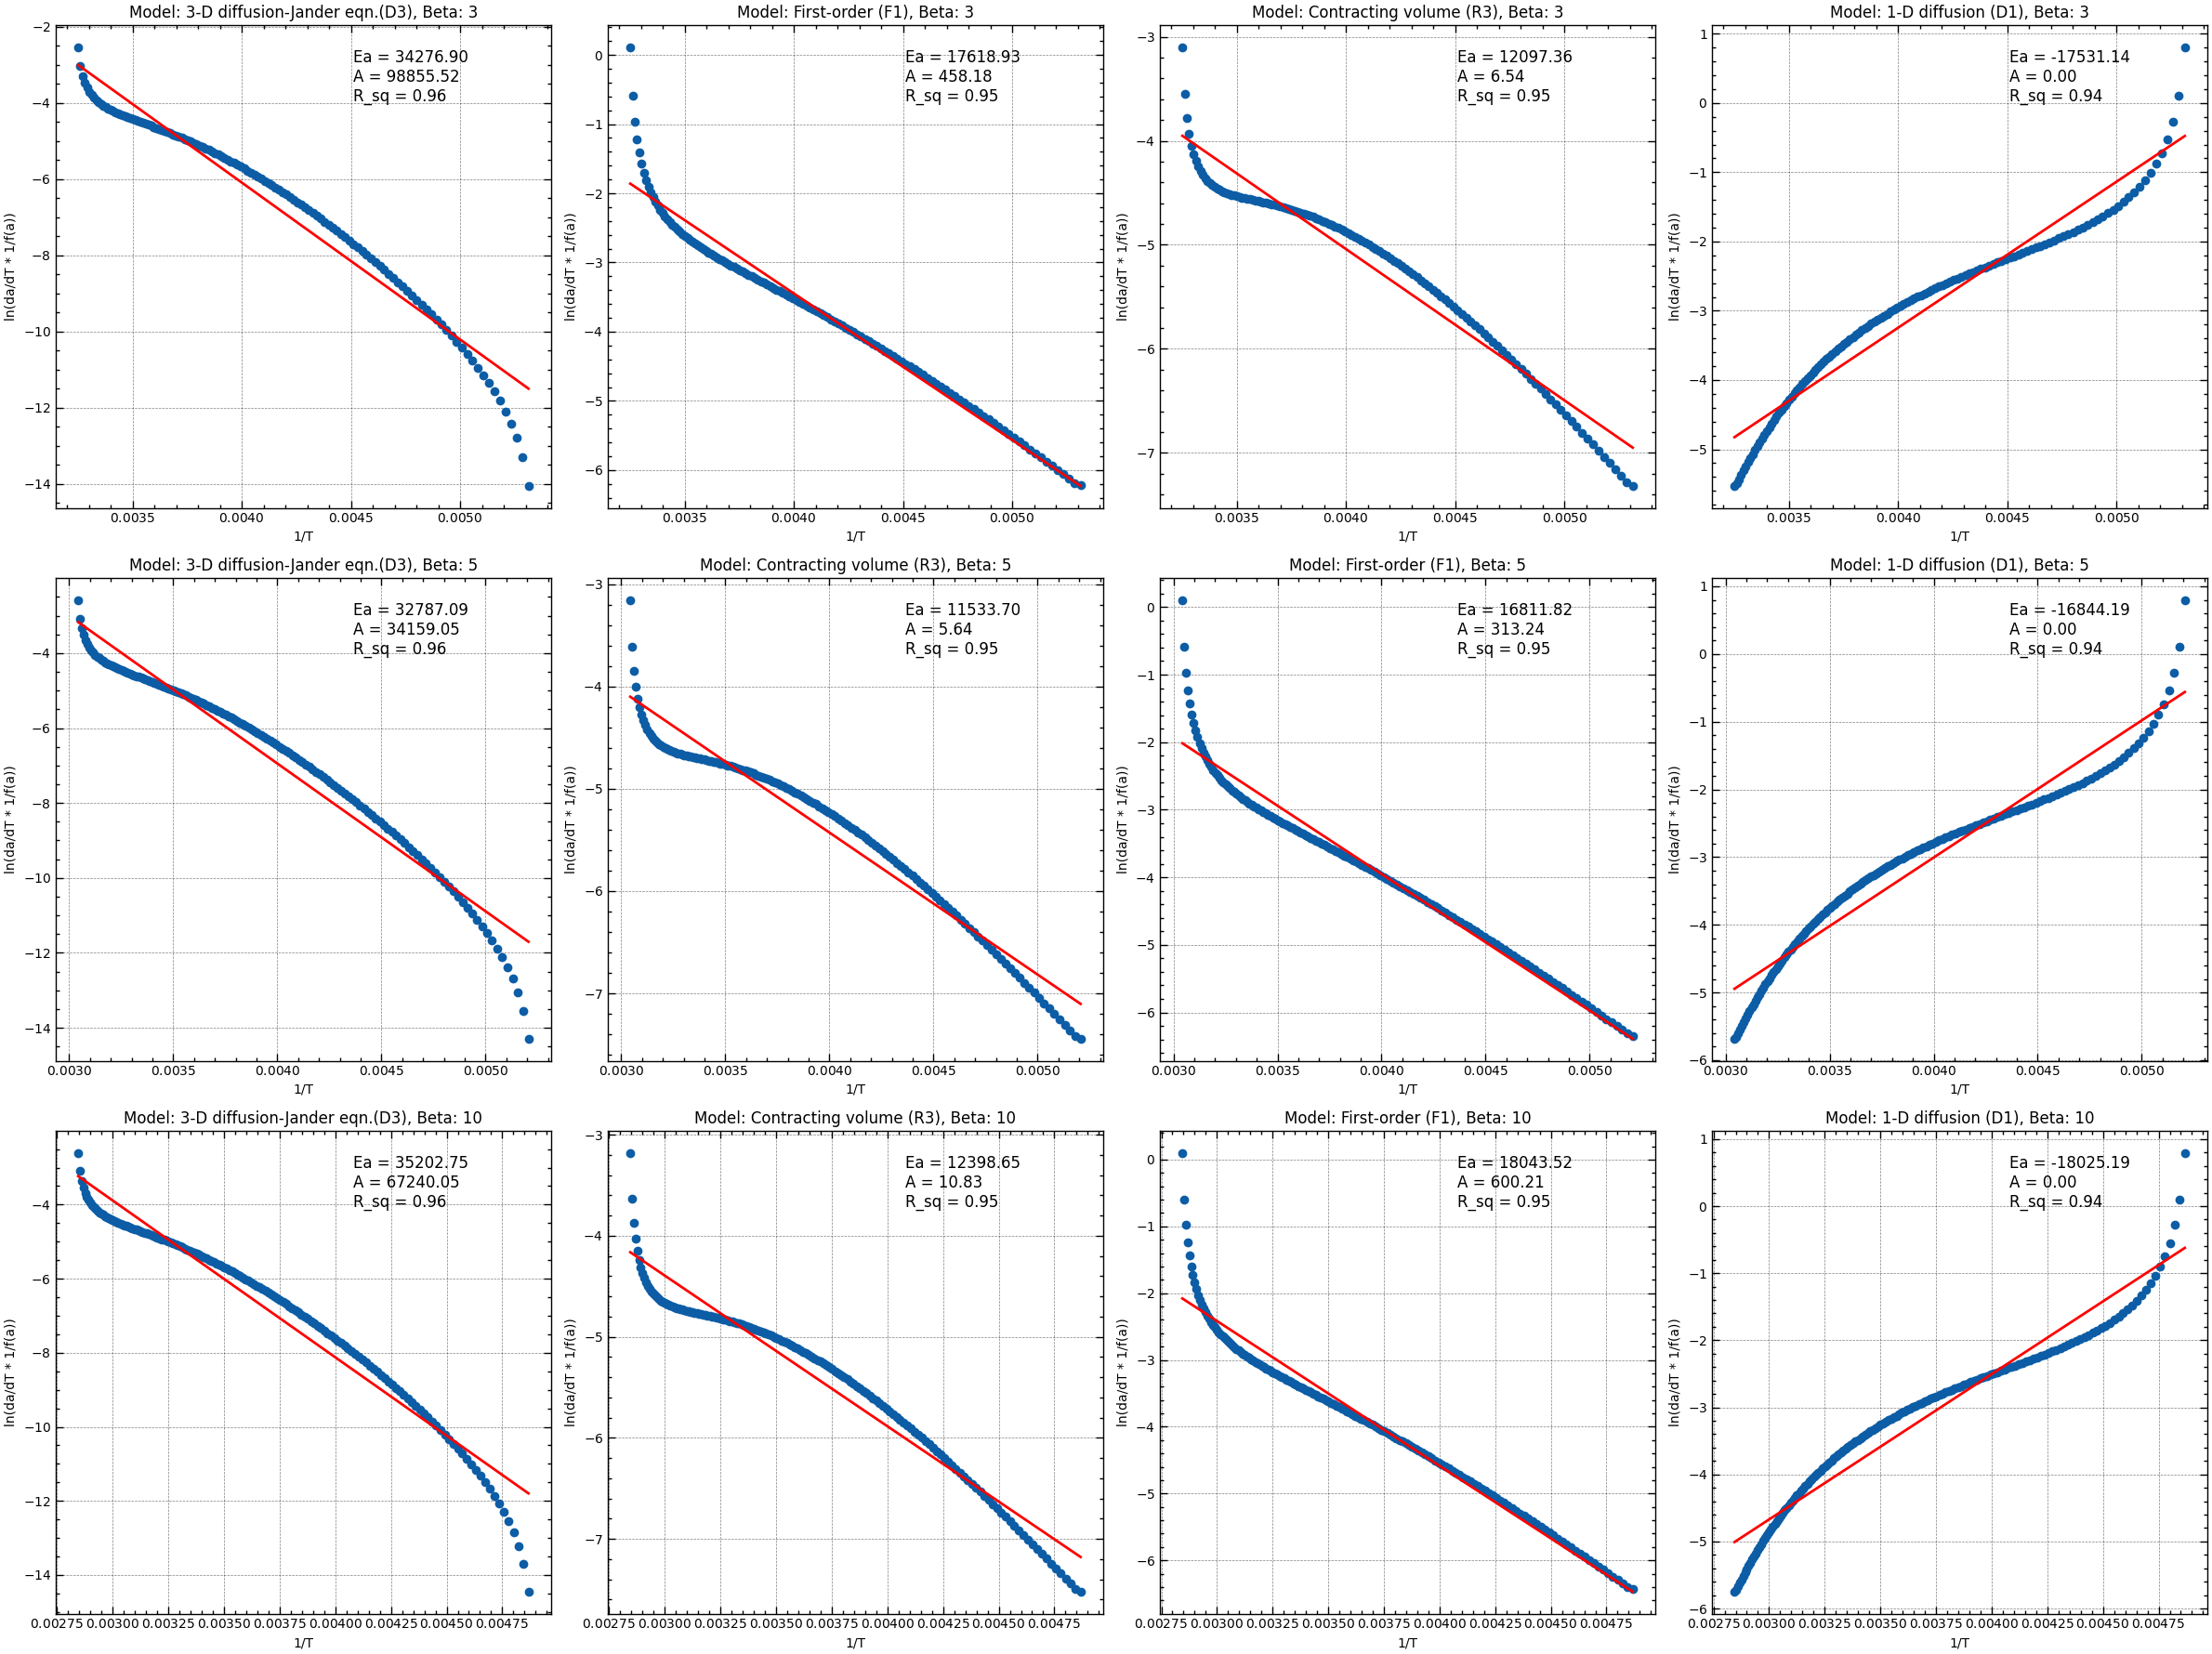

In [171]:
fig, axs = plt.subplots(3, 4, figsize=(24, 18))  # 3 строки, 4 столбца

for j, beta in enumerate(heating_rates):
    # Создаем фильтр для каждого beta
    beta_filter = direct_diff['beta'] == beta
    
    # Применяем фильтр к DataFrame и сортируем его по 'R_sq'
    top_4_models = direct_diff[beta_filter].sort_values('R_sq', ascending=False).head(4)
    
    for i, (idx, row) in enumerate(top_4_models.iterrows()):
        model = row['Equation']
        model_name = row['Model']
        
        temperature, conversion = get_data(reactions_df, beta)
        da_dT = calculate_derivative(temperature, conversion)
        f_a_val = model_func(model, conversion)
        lhs = calculate_direct_diff_lhs(da_dT, f_a_val)
        temperature_clean, lhs_clean = filter_data(lhs, temperature)
        
        # Строим график для каждой модели
        axs[j][i].plot(1/temperature, lhs, 'o')
        axs[j][i].set_title(f'Model: {model_name}, Beta: {beta}', fontsize=BIG_SIZE)
        axs[j][i].set_xlabel('1/T', fontsize=MEDIUM_SIZE)
        axs[j][i].set_ylabel('ln(da/dT * 1/f(a))', fontsize=MEDIUM_SIZE)
        
        # Выполняем линейную регрессию и строим прямую линию
        slope, intercept, _, _, _ = perform_regression(temperature_clean, lhs_clean)
        axs[j][i].plot(1/temperature, slope*(1/temperature) + intercept, 'r-')
        
        # Выводим значения Ea, A, R_sq, R_corr, Spearman_corr, Kendall_corr на график
        Ea = row['Ea']
        A = row['A']
        r_sq = row['R_sq']        
        axs[j][i].text(0.60, 0.95, f'Ea = {Ea:.2f}\nA = {A:.2f}\nR_sq = {r_sq:.2f}', transform=axs[j][i].transAxes, fontsize=BIG_SIZE, verticalalignment='top')
        axs[j][i].tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)

plt.tight_layout()
plt.show()

$$Метод~Фримена~и~Кэрролла$$
Взятие натурального логарифма от дифференциальной формы закона скорости неизотермической реакции (уравнение 9) дает:

$$
\ln \frac{da}{dT} = \ln \frac{A}{\beta} - \frac{Ea}{RT} + \ln f(a) \tag{11}
$$

Если взять приращения переменных в уравнении 11, мы получим:

$$
\Delta \ln \frac{d\alpha}{dT} = \Delta \ln f(\alpha) - \frac{Ea}{R} \Delta \frac{1}{T} \tag{12}
$$

Разделив обе части уравнения на приращение обратной температуры получим:

$$
\frac{\Delta \ln \frac{d\alpha}{dT}}{\Delta \frac{1}{T}} = \frac{\Delta \ln f(\alpha)}{\Delta \frac{1}{T}} - \frac{Ea}{R} \tag{13}
$$

или

$$
\frac{\Delta \ln \frac{d\alpha}{dT}}{\Delta \ln f(\alpha)} = -\frac{Ea}{R} \frac{\Delta \frac{1}{T}}{\Delta \ln f(\alpha)} \tag{14}
$$

Активационная энергия может быть получена путем построения графика левой части уравнений (13) против $\Delta \ln f(\alpha) / \Delta \frac{1}{T}$ в точке пересечения с осью ординат. В случае уравнения (14) левая часть против $\Delta \frac{1}{T} / \Delta \ln f(\alpha)$ с нахождением угла наклона прямой.


In [172]:
def main_friedman_carroll(df, models_df):
    # Отключение предупреждений
    warnings.filterwarnings('ignore')

    # Создание нового DataFrame для хранения результатов
    result_df = pd.DataFrame(columns=[
        'Model', 'beta', 'Equation', 'R_corr_13', 'R_corr_14', 
        'R_std_13', 'R_std_14', 'R_sq_13', 'R_sq_14', 'Ea_13', 'Ea_14'])

    # Извлечение данных из DataFrame моделей
    f_a = models_df['Differential Form'].to_list()
    f_names = models_df['Model'].to_list()  

    # Цикл по каждой модели и каждому темпу нагрева
    for i, model in enumerate(f_a):
        for beta in heating_rates:
            try:
                # Получение данных для заданной модели и темпа нагрева
                temperature, conversion = get_data(df, beta)

                # Создание нового DataFrame для хранения производных и логарифмов
                data = pd.DataFrame(index=temperature)
                data['conversion'] = conversion
                data['log_da_dT'] = np.log(np.gradient(conversion, temperature))
                data['f_a_val'] = model_func(model, conversion)
                data['log_f_a_val'] = np.log(data['f_a_val'])
                data['inv_T'] = 1 / temperature 

                # Вычисление дельты для всех столбцов
                data = data.diff()

                # Вычисление левой части по уравнению 13
                data['lhs_13'] = data['log_da_dT'] / data['inv_T']
                
                # Вычисление левой части по уравнению 14
                data['lhs_14'] = data['log_da_dT'] / data['log_f_a_val']

                # Исключение NaN значений
                data = data.dropna()

                # Находим пересечение с осью ординат прямой для ур. 13
                _, intercept_13, r_value_13, _, std_err_13 = perform_regression(
                    data['lhs_13'], 
                    data['log_f_a_val'] / data['inv_T'])

                # Вычисляем Ea_13
                Ea_13 = intercept_13 * -R                
                
                # Находим угол наклона прямой для ур. 14
                slope_14, _, r_value_14, _, std_err_14 = perform_regression(
                    data['lhs_14'], 
                    data['inv_T'] / data['log_f_a_val'])
                
                # Вычисляем Ea_14
                Ea_14 = slope_14 * -R                
                
                # Создание temp_df
                temp_df = pd.DataFrame({'Model': [f_names[i]],
                                        'beta': [beta],
                                        'Equation': [model],
                                        'R_corr_13': [r_value_13],
                                        'R_corr_14': [r_value_14],
                                        'R_std_13': [std_err_13],
                                        'R_std_14': [std_err_14],
                                        'Ea_13': [Ea_13],
                                        'Ea_14': [Ea_14],
                                        'R_sq_13': [r_value_13**2],
                                        'R_sq_14': [r_value_14**2]
                                        })

                # Конкатенация temp_df с result_df
                result_df = pd.concat([result_df, temp_df], ignore_index=True)
            except TypeError:
                print(f"TypeError occurred for model: {f_names[i]}")

    # Включение обратно предупреждений
    warnings.filterwarnings('default')
    return result_df

friedman_carroll = main_friedman_carroll(reactions_df, models_df)
friedman_carroll.sort_values(by='R_sq_13', ascending=False).head(15)


,Model,beta,Equation,R_corr_13,R_corr_14,R_std_13,R_std_14,R_sq_13,R_sq_14,Ea_13,Ea_14
19,Prout–Tompkins (B1),5,a*(1 - a)*np.log(a/(1 - a)),0.681863,0.999751,0.729087,0.000001,0.464937,0.999503,116322.569553,-0.003853
15,Avarami-Erofe’ev (A4),3,4*(1 - a)*(-np.log(1 - a))**(3/4),0.680080,0.996009,0.225594,0.000058,0.462509,0.992034,-1165.617193,-0.060107
12,Avarami-Erofe’ev (A3),3,3*(1 - a)*(-np.log(1 - a))**(2/3),0.675813,-0.997970,0.226550,0.000088,0.456723,0.995943,-3748.607620,0.127419
18,Prout–Tompkins (B1),3,a*(1 - a)*np.log(a/(1 - a)),0.674908,0.999534,0.824791,0.000002,0.455501,0.999067,125722.800649,-0.003765
20,Prout–Tompkins (B1),10,a*(1 - a)*np.log(a/(1 - a)),0.667021,0.999597,0.763811,0.000001,0.444918,0.999195,131286.576882,-0.003589
9,Avarami-Erofe’ev (A2),3,2*(1 - a)*(-np.log(1 - a))**(1/2),0.665509,-0.999278,0.229497,0.000007,0.442903,0.998557,-8914.588473,0.016767
16,Avarami-Erofe’ev (A4),5,4*(1 - a)*(-np.log(1 - a))**(3/4),0.659550,0.990451,0.232005,0.000086,0.435006,0.980993,-881.113647,-0.060905
13,Avarami-Erofe’ev (A3),5,3*(1 - a)*(-np.log(1 - a))**(2/3),0.655509,-0.793109,0.233326,0.000667,0.429692,0.629021,-3357.710227,0.085745
17,Avarami-Erofe’ev (A4),10,4*(1 - a)*(-np.log(1 - a))**(3/4),0.650321,0.943023,0.233549,0.000180,0.422917,0.889292,-1043.024070,-0.052214
14,Avarami-Erofe’ev (A3),10,3*(1 - a)*(-np.log(1 - a))**(2/3),0.646291,-0.812181,0.234866,0.000583,0.417692,0.659638,-3714.393576,0.082947


$$ Интегральные~методы$$

Интегрирование дифференциального неизотермического уравнения скорости приводит к интегральной форме неизотермического уравнения скорости:

$$ g(a) = \frac{A}{\beta} \int_{0}^{T} e^{\frac{-Ea}{RT}} dT \tag{15} $$

Этот интеграл называется температурным интегралом и не имеет аналитического решения. Чтобы преобразовать вышеупомянутый интеграл в более общую форму, которую можно найти в математических справочниках, переменную интегрирования можно переопределить как,

$$x = \frac{Ea}{RT}$$

и температурный интеграл становится:

$$ g(a) = \frac{AEa}{\beta R} \int_{x}^{\infty} \frac{e^{-x}}{x^2} dx \tag{16} $$

Если $p(x) = \int_{x}^{\infty} \frac{e^{-x}}{x^2} dx$, тогда уравнение 16 может быть записано как:

$$g(a) = \frac{AE_a}{\beta R} p(x) \tag{17}$$

где $p(x)$ - экспоненциальный интеграл. Основные подходы, используемые для оценки температурного/экспоненциального интеграла, включают:

1. Вычисление значений $p(x)$ численно.
2. Преобразование $p(x)$ в приближенную форму, которую можно интегрировать.
3. Аппроксимация $p(x)$ рядом разложения.


Два наиболее используемых ряда для аппроксимации температурного интеграла:

I. Асимптотическое разложение в ряд

$$p(x) = \frac{e^{-x}}{x^2} \left(1 - \frac{1}{2!x} + \frac{1}{3!x^2} - \frac{1}{4!x^3} + \ldots + (-1)^n \frac{n}{(n+1)!x^n} + \ldots \right)$$

II. Разложение в ряд Шлёмилха

$$p(x) = \frac{e^{-x}}{x(x+1)} \left(1 - \frac{1}{(x+2)} + \frac{2}{(x+2)(x+3)} - \frac{4}{(x+2)(x+3)(x+4)} + \ldots \right)$$

Многие приближения были предложены для температурного интеграла, два из которых будут рассмотрены - это приближения Дойла и Сенума-Янга. Они являются одними из наиболее распространенных приближений температурного/экспоненциального интеграла, так как каждое из них является основой для конкретного метода кинетического расчета.

$$ Приближение~Дойля $$ 

Приближение экспоненциального интеграла ($p(x)$) Дойлем основано на наблюдении, что $\log p(x)$ довольно линейно относительно $x$ в небольшом диапазоне значений $x$. Дойль приближал значения $p(x)$, используя первые три члена ряда Шлёмилха и наблюдаемое линейное соотношение для $x = 28–50$, чтобы получить по регрессии следующее приближение температурного интеграла:

$$\log p(x) = -2.315 - 0.4567x \tag{18}$$

Определено, что качество этой линейной зависимости довольно высоко с $R^2 = 0.99999$.

$$Приближение~Сенума-Янга$$ 

Сенум и Янг разработали точное нелинейное приближение температурного интеграла. Если переменные в Ур. 16 преобразуются так, что $x = zy$, то интеграл становится,

$$g(a) = \frac{AEa}{Rz} \int_{1}^{\infty} \frac{e^{zy}}{y^2} dy$$


Которое можно записать как,

$$g(a) = \frac{AEa}{Rz} E_2(z) \tag{19}$$

$E_2(z)$ или, в общем случае, $E_v(z)$ (где $v$ - целое число) - это хорошо известный интеграл для $z > 0$, заданный следующей непрерывной дробью:

$$\frac{E_v(z)}{z} = \frac{e^{-z}}{z} \cdot \cfrac{e^z}{z + \cfrac{v}{1 + \cfrac{1}{z + \cfrac{v+1}{1 + \cfrac{2}{z + \ddots}}}}} $$

Усечение числа членов в вышеприведенной непрерывной дроби дает первое (один член), второе (два члена), третье (три члена) и четвертое (четыре члена) рациональные приближения, известные как приближения Сенума-Янга.

$$ 1.~~p(x) = \frac{e^x}{x} - \frac{1}{x + 2} $$
$$ 2.~~p(x) = \frac{e^x}{x} - \frac{x + 4}{x^2 + 6x + 6} $$
$$ 3.~~p(x) = \frac{e^x}{x} - \frac{x^2 + 10x + 18}{x^3 + 12x^2 + 36x + 24} $$
$$ 4.~~p(x) = \frac{e^x}{x} - \frac{x^3 + 18x^2 + 86x + 96}{x^4 + 20x^3 + 120x^2 + 240x + 120} $$


$$ Метод~Коутса–Редферна $$

Этот метод использует интегральную форму неизотермического закона скорости (уравнение 17). Коутс и Редферн использовали асимптотическое разложение ряда для приближения температурного интеграла (p(x)), получив:

$$\ln\left(\frac{g(a)}{T^2}\right) = \ln\left(\frac{AR}{\beta E_a} \left[1 - \frac{2RT_{\text{exp}}}{E_a}\right]\right) + \frac{E_a}{RT} \tag{20}$$



где $T_{\text{exp}}$ - средняя экспериментальная температура. Построение графика левой части (включая модель, $g(a)$) уравнения 20 в отношении $1/T$ дает энергию активации ($E_a$) и частотный фактор (A) от угла наклона прямой и пересечения с осью ординат, соответственно. Выбирается модель, которая дает наилучшую линейную аппроксимацию. 

In [173]:
# Эта функция вычисляет левую часть уравнения Coats-Redfern
def calculate_coats_redfern_lhs(g_a_val, T):
    try:
        # Вычисляем значение левой части уравнения Coats-Redfern
        # Если возникает ошибка деления на ноль, возвращаем бесконечность
        return np.log(g_a_val / (T**2))
    except ZeroDivisionError:
        return np.inf

# Фильтрация данных, удаляя все нечисловые значения
def filter_data(lhs, inverse_T):
    # Создаем маску для значений, которые являются числами в обоих массивах
    mask = np.isfinite(lhs) & np.isfinite(inverse_T)
    # Применяем маску к обоим массивам и возвращаем результат
    return inverse_T[mask], lhs[mask]

# Вычисление параметров модели
def calculate_coats_redfern_params(slope, intercept, beta):    
    # Вычисляем энергию активации на основе угла наклона прямой регрессии
    Ea = -slope * R
    # Вычисляем предэкспоненциальный множитель на основе пересечения оси Y прямой регрессии
    A = np.exp(intercept) * int(beta) / R
    return Ea, A

# Главная функция, где происходит весь процесс
def main(df, models_df):
    # Отключаем предупреждения
    warnings.filterwarnings('ignore')
    
    # Создаем новый DataFrame для хранения результатов
    coats_redfern = pd.DataFrame(columns=[
        'Model', 'beta', 'Equation', 'R_corr', 'R_sq', 'R_std', 'Ea', 'A'])
    # Получаем список интегральных форм моделей
    g_a = models_df['Integral Form'].to_list()
    # Получаем имена моделей
    g_names = models_df['Model'].to_list()    

    # Проходим по каждой модели и каждому темпу нагрева
    for i, model in enumerate(g_a):
        for beta in heating_rates:
            # Получаем данные температуры и степени превращения для данной модели и темпа нагрева
            temperature, conversion = get_data(df, beta)
            # Вычисляем значение интегральной функции для степени превращения
            g_a_val = model_func(model, conversion)
            # Вычисляем обратное значение температуры
            inverse_T = 1 / temperature
            # Вычисляем левую часть уравнения Coats-Redfern
            lhs = calculate_coats_redfern_lhs(g_a_val, inverse_T)
            # Фильтруем данные, удаляя нечисловые значения
            inverse_T_clean, lhs_clean = filter_data(lhs, inverse_T)
            # Выполняем линейную регрессию на очищенных данных
            slope, intercept, r_value, p_value, std_err = perform_regression(inverse_T_clean, lhs_clean)
            # Вычисляем параметры модели
            Ea, A = calculate_coats_redfern_params(slope, intercept, beta)           

            # Создание temp_df
            temp_df = pd.DataFrame({'Model': [g_names[i]],
                                    'beta': [beta],
                                    'Equation': [model],
                                    'R_corr': [r_value],
                                    'R_std': [std_err],
                                    'Ea': [Ea],
                                    'A': [A],
                                    'R_sq': [r_value**2]
                                    })

            # Конкатенация temp_df с coats_redfern
            coats_redfern = pd.concat([coats_redfern, temp_df], ignore_index=True)

    # Включаем предупреждения обратно
    warnings.filterwarnings('default')
    return coats_redfern

# Вызываем главную функцию и сохраняем результаты
coats_redfern = main(reactions_df, models_df)
top_20_cr = coats_redfern.sort_values(by='R_sq', ascending=False).head(20)
top_20_cr


,Model,beta,Equation,R_corr,R_sq,R_std,Ea,A
16,Avarami-Erofe’ev (A4),5,(-np.log(1 - a))**(1/4),-0.996437,0.992886,8.606288,10073.692428,3.878594e+06
17,Avarami-Erofe’ev (A4),10,(-np.log(1 - a))**(1/4),-0.996356,0.992726,9.012761,10793.052859,8.932481e+06
15,Avarami-Erofe’ev (A4),3,(-np.log(1 - a))**(1/4),-0.995735,0.991489,10.166253,10158.992716,2.747110e+06
13,Avarami-Erofe’ev (A3),5,(-np.log(1 - a))**(1/3),-0.995171,0.990364,11.989584,12043.196487,9.252840e+06
14,Avarami-Erofe’ev (A3),10,(-np.log(1 - a))**(1/3),-0.995070,0.990164,12.548001,12905.556270,2.135433e+07
12,Avarami-Erofe’ev (A3),3,(-np.log(1 - a))**(1/3),-0.994333,0.988698,14.105681,12214.904405,7.135386e+06
10,Avarami-Erofe’ev (A2),5,(-np.log(1 - a))**(1/2),-0.993249,0.986543,18.839924,15982.204605,5.265948e+07
11,Avarami-Erofe’ev (A2),10,(-np.log(1 - a))**(1/2),-0.993121,0.986288,19.704142,17130.563094,1.220432e+08
9,Avarami-Erofe’ev (A2),3,(-np.log(1 - a))**(1/2),-0.992280,0.984619,22.040277,16326.727782,4.813935e+07
43,First-order (F1),5,-np.log(1 - a),-0.990217,0.980531,39.536692,27799.228960,9.706914e+09


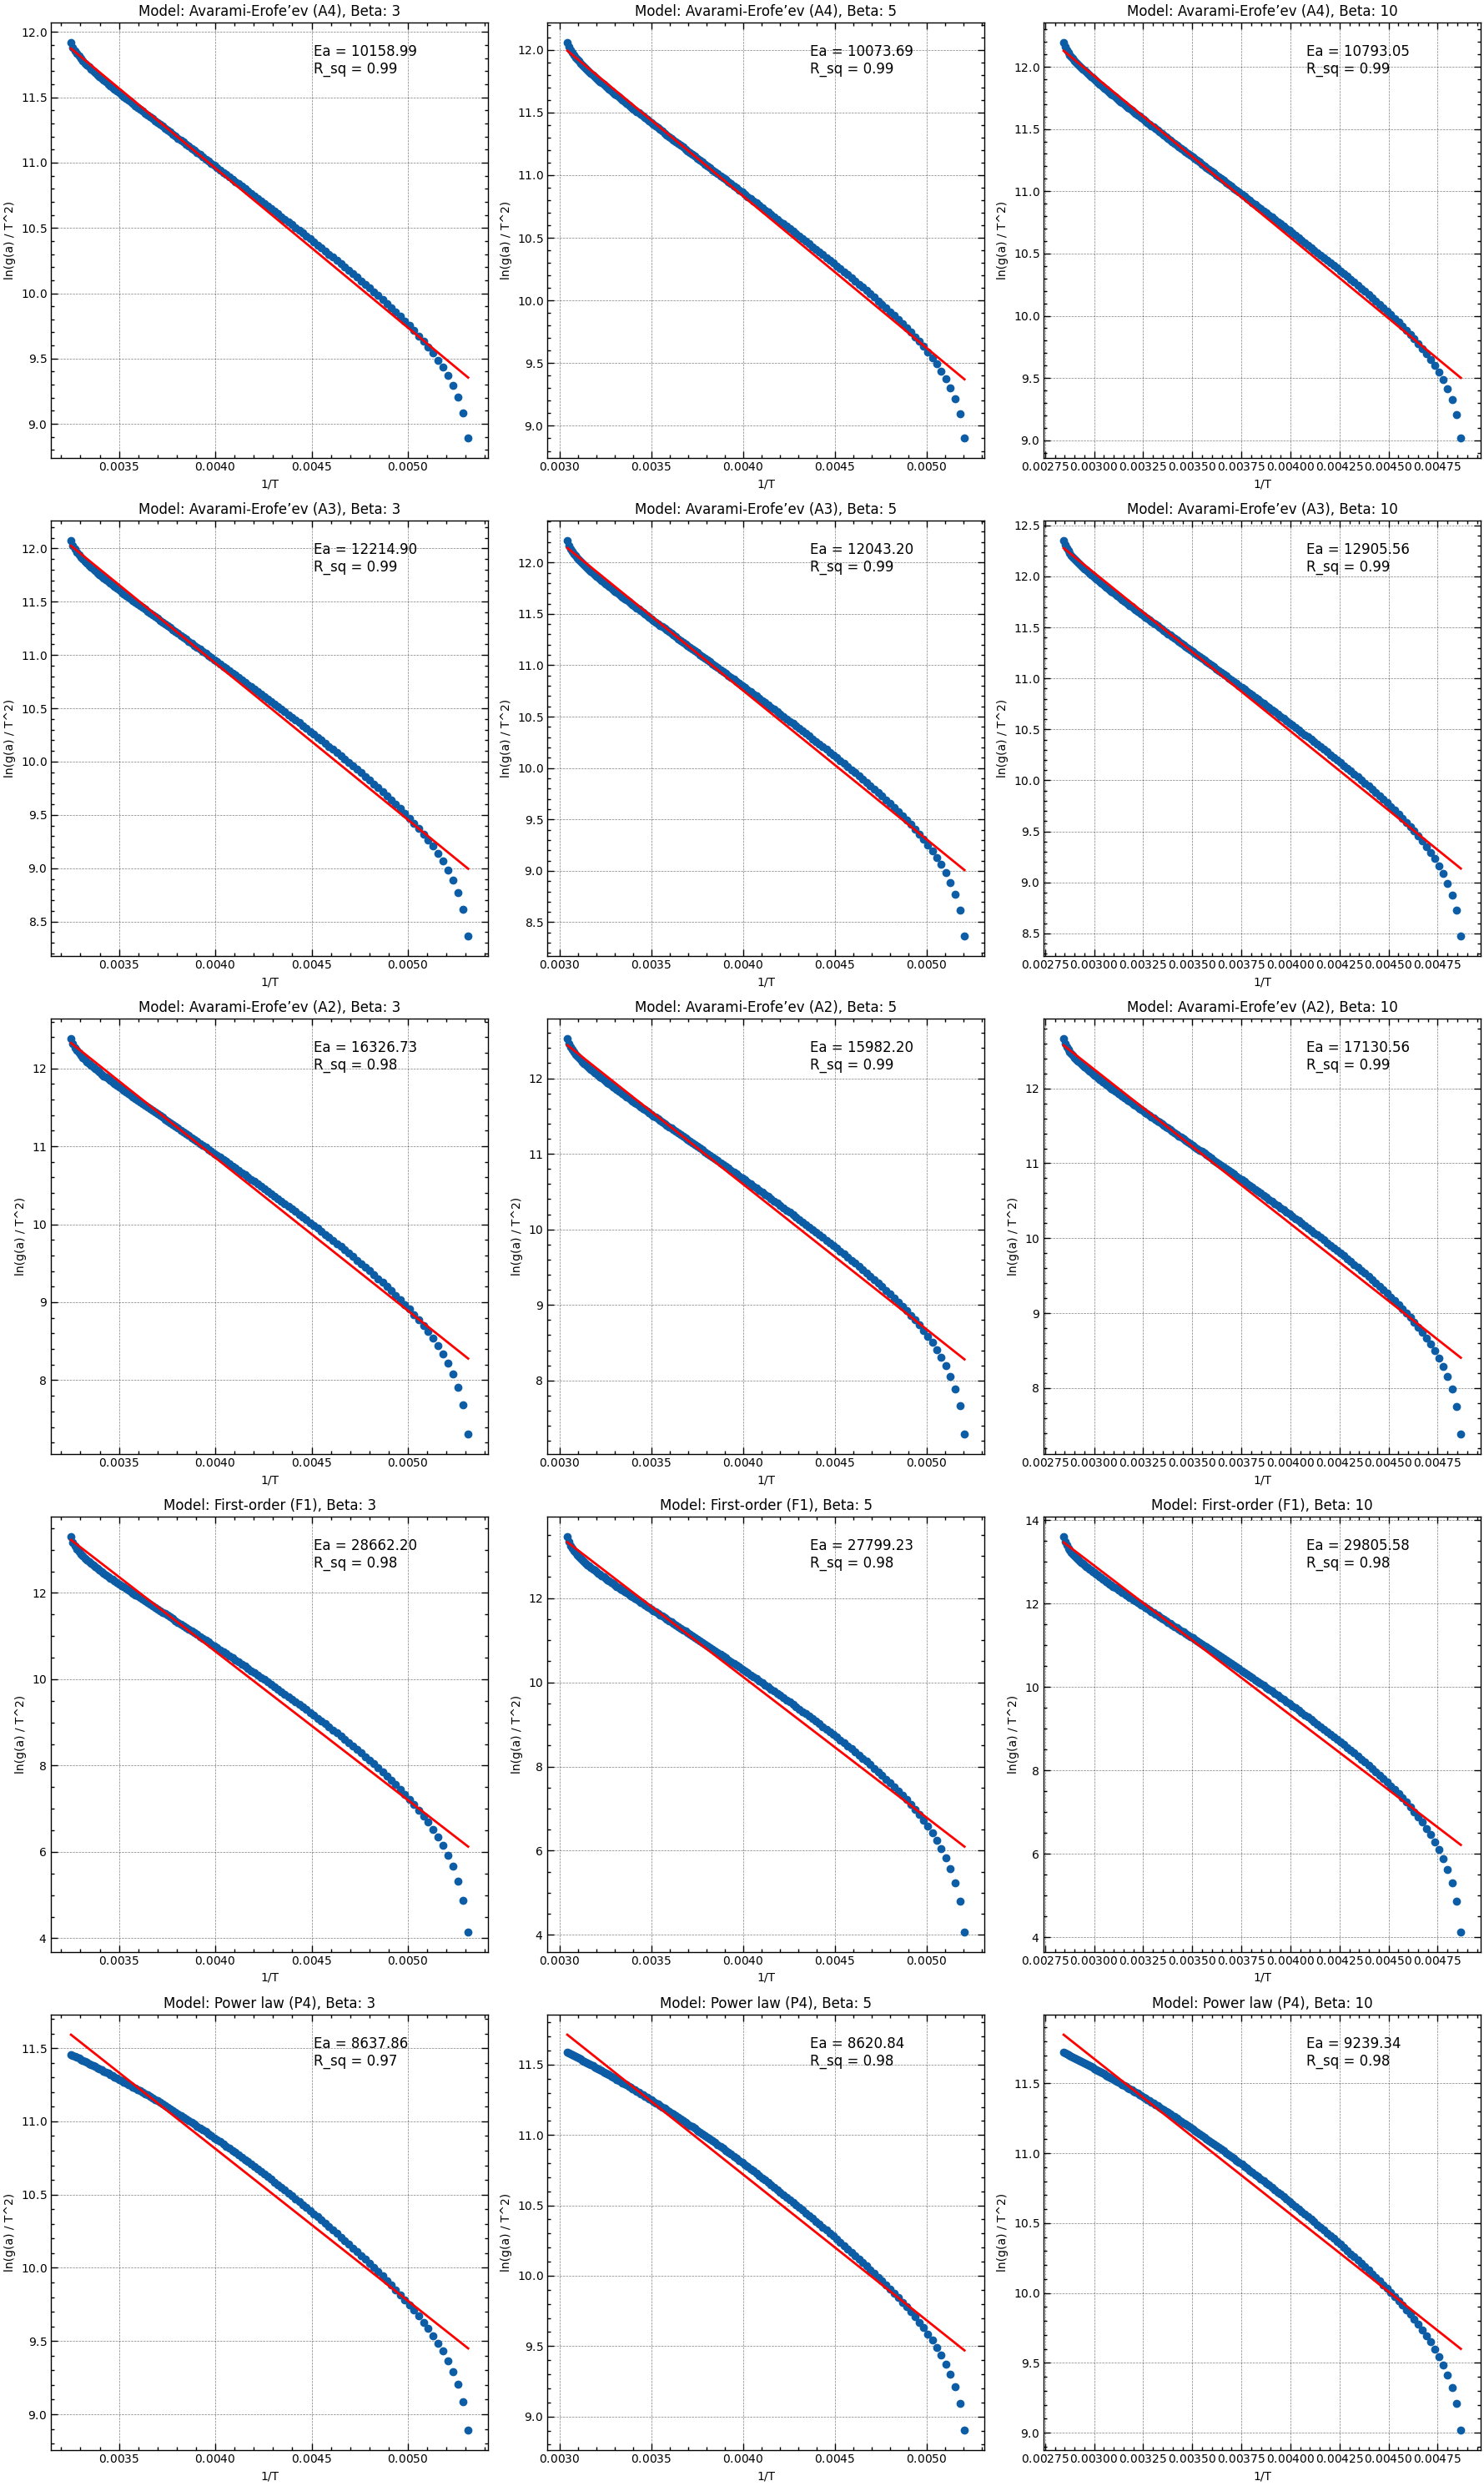

In [174]:
# На основе Coats-Redfern
def filter_data(lhs, temperature, x_val):
    mask = ~np.isnan(lhs) & ~np.isnan(temperature) & ~np.isnan(x_val)
    return temperature[mask], lhs[mask], x_val[mask]

# Устанавливаем число моделей для вывода на экран
NUM_MODELS = 5

fig, axs = plt.subplots(NUM_MODELS, len(heating_rates), figsize=(18, NUM_MODELS*6))  # NUM_MODELS строк, len(heating_rates) столбцов

for i in range(NUM_MODELS):
    for j, beta in enumerate(heating_rates):
        # Создаем фильтр для каждого beta
        beta_filter = coats_redfern['beta'] == beta
        # Применяем фильтр к DataFrame и сортируем его по 'R_sq'
        top_models = coats_redfern[beta_filter].sort_values('R_sq', ascending=False)
        
        if i < len(top_models):
            row = top_models.iloc[i]
            model = row['Equation']
            model_name = row['Model']
            
            temperature, conversion = get_data(reactions_df, beta)
            g_a_val = model_func(model, conversion)
            inverse_T = 1 / temperature
            lhs = calculate_coats_redfern_lhs(g_a_val, inverse_T)
            x_val = inverse_T
            temperature_clean, lhs_clean, x_val_clean = filter_data(lhs, temperature, x_val)

            # Строим график для каждой модели
            axs[i][j].plot(x_val_clean, lhs_clean, 'o')
            axs[i][j].set_title(f'Model: {model_name}, Beta: {beta}', fontsize=BIG_SIZE)
            axs[i][j].set_xlabel('1/T', fontsize=MEDIUM_SIZE)
            axs[i][j].set_ylabel('ln(g(a) / T^2)', fontsize=MEDIUM_SIZE)

            # Выполняем линейную регрессию и строим прямую линию
            slope, intercept, _, _, _ = perform_regression(x_val_clean, lhs_clean)
            axs[i][j].plot(x_val_clean, slope*x_val_clean + intercept, 'r-')

            # Выводим значения Ea, R_sq, R_corr, Spearman_corr, Kendall_corr на график
            Ea = row['Ea']
            r_sq = row['R_sq']                      
            axs[i][j].text(0.60, 0.95, f'Ea = {Ea:.2f}\nR_sq = {r_sq:.2f}', transform=axs[i][j].transAxes, fontsize=BIG_SIZE, verticalalignment='top')
            axs[i][j].tick_params(axis='both', which='both', labelsize=MEDIUM_SIZE)

plt.tight_layout()
plt.show()


$$ Безмодельные~методы $$
Как говорилось выше, уравнение 15 не имеет аналитического решения. По этой причине существует ряд интегральных изоконверсионных методов, которые отличаются аппроксимациями температурного интеграла $p(x)$. Многие из этих аппроксимаций приводят к линейным уравнениям общего вида:

$$\ln\left(\frac{{\alpha}_i}{T^B_i}\right) = \text{Const} - \frac{CE_a}{RT_a} \tag{21}$$

где B и C - параметры, определяемые типом аппроксимации температурного интеграла. Например, очень грубая аппроксимация Дойля, которая была выполнена для $x = 28–50$, где $x = \frac{Ea}{RT}$, дает B = 0 и C = 1.052, так что уравнение (21) принимает форму, также известную как уравнение Озавы, и/или Флинна и Уолла:

$$\ln({\alpha}_i) = \text{Const} - \frac{1.052E_a}{RT_a} \tag{22}$$

Грубая аппроксимация температурного интеграла приводит к неточным значениям $E_a$. Более точную аппроксимацию дают Мюррей и Уайт, они получают B = 2 и C = 1 и приводят к другому популярному уравнению, которое часто называют уравнением Киссинджера-Акахира-Суносе:

$$\ln\left(\frac{{\alpha}_i}{T^2_i}\right) = \text{Const} - \frac{E_a}{RT_a} \tag{23}$$

По сравнению с методом Озавы-Флинна-Уолла, метод Киссинджера-Акахира-Суносе предлагает значительное улучшение точности значений $E_a$. Как показал Старинк, несколько более точные оценки $E_a$ достигаются при установке B = 1.92 и C = 1.0008, так что уравнение (21) преобразуется в:

$$\ln\left(\frac{{\alpha}_i}{T^{1.92}_i}\right) = \text{Const} - \frac{1.0008E_a}{RT_a} \tag{24}$$

Поскольку вышеупомянутые уравнения (21) - (24) одинаково легко решить, применяя анализ линейной регрессии, рекомендуется использовать более точные уравнения, такие как (23) и (24).  Здесь следует настоятельно рекомендовать против часто встречающейся практики выполнения и отчетности по кинетическому анализу на основе одновременного использования более чем одной формы уравнения (21). Одновременное использование двух или более таких уравнений только раскрывает тривиальное различие в значениях $E_a$, вычисленных методами разной точности. Поскольку из такого сравнения не получается кинетическая информация, практику одновременного использования уравнений (21) - (24) следует исключить в пользу использования только одного более точного уравнения.


In [175]:
def closest_conversion_t(beta: str, conversion: float, df: pd.DataFrame) -> float:
    beta = int(beta)
    query = f'conversion_Synthesis_{beta}'
    column = df[query].dropna()
    absolute_differences = np.abs(column - conversion)
    closest_index = absolute_differences.idxmin()
    return closest_index

def mins_to_seconds(rate: str) -> int:
    """Преобразует минуты в секунды

    Args:
        rate (str): Строка, содержащая значение в минутах
    Returns:
        int: Преобразованное значение в секундах
    """
    return int(rate) / 60

def calculate_Ea(conversion: float) -> np.float64:
    """Вычисляет активационную энергию по различным уравнениям.

    Args:
        conversion (float): Значение конверсии
        temperature (float): Значение температуры в градусах Цельсия
        reaction (str): Название реакции.
    Returns:
        np.float64: Значение активационной энергии
    """
    
    # Вычисляем лонарифм скорости нагрева в секундах
    betta = [np.log(mins_to_seconds(rate)) for rate in heating_rates]

    # Вычисляем значение обратной абсолютной температуры для графика
    log_T = [1 / (closest_conversion_t(rate, conversion, reactions_df) + 273.15) for rate in heating_rates]

    # Вычисляем коэффициенты полинома первого порядка для уравнения Озавы-Флинна-Уолла
    coefficient_OFW = np.polyfit(log_T, betta, 1)

    # Вычисляем активационную энергию по уравнению Озавы-Флинна-Уолла
    Ea_OFW = coefficient_OFW[0] * R / -1.052
    
    # Вычисляем лонарифм отношения скорости нагрева к квадрату абсолютной температуры
    betta = [np.log(mins_to_seconds(rate) / (closest_conversion_t(rate, conversion, reactions_df) + 273.15)**2) 
             for rate in heating_rates]

    # Вычисляем коэффициенты полинома первого порядка для уравнения Киссенджера-Акахиры-Суносе
    coefficient_KAS = np.polyfit(log_T, betta, 1)

    # Вычисляем активационную энергию по уравнению Киссенджера-Акахиры-Суносе
    Ea_KAS = -coefficient_KAS[0] * R

    # Вычисляем лонарифм отношения скорости нагрева к 1.92 степени абсолютной температуры
    betta = [np.log(mins_to_seconds(rate) / ((closest_conversion_t(rate, conversion, reactions_df) + 273.15))**1.92) 
             for rate in heating_rates]

    # Вычисляем коэффициенты полинома первого порядка для улучшенного уравнения
    coefficient_improved = np.polyfit(log_T, betta, 1)

    # Вычисляем активационную энергию по улучшенному уравнению
    Ea_improved = -coefficient_improved[0] * R / 1.0008
    
    return Ea_OFW, Ea_KAS, Ea_improved

In [176]:
# создаем пустой список для хранения данных
data = []

# Задаем кол-во точек в которых будет проводиться расчет Ea
VALUE_NUMBER = 11
conversion_values = np.arange(0.01, 0.99, 0.01)

# для каждого значения конверсии
for conversion in conversion_values:
    # вычисляем активационную энергию по различным методам
    Ea_values = calculate_Ea(conversion)
    
    # добавляем результаты в список
    data.append({'conversion': conversion,                     
                 'Ea_OFW': Ea_values[0],
                 'Ea_KAS': Ea_values[1],
                 'Ea_improved': Ea_values[2]}) 

# преобразуем список в DataFrame
Ea_df = pd.DataFrame(data)

# задаем имена столбцов
Ea_df.columns = ['conversion', 'Ea_OFW', 'Ea_KAS', 'Ea_improved']

Ea_df


,conversion,Ea_OFW,Ea_KAS,Ea_improved
0,0.01,112752.826273,110722.683050,110949.654933
1,0.02,108368.641185,106038.668882,106272.256742
2,0.03,109667.956922,107357.898162,107592.335994
3,0.04,105255.749700,102660.344409,102900.771962
4,0.05,103241.979102,100502.331893,100746.064246
...,...,...,...,...
93,0.94,80865.127157,75369.458175,75696.926857
94,0.95,81395.953701,75896.098220,76224.416490
95,0.96,80110.302652,74505.625378,74836.572641
96,0.97,80894.261306,75282.664105,75614.896140


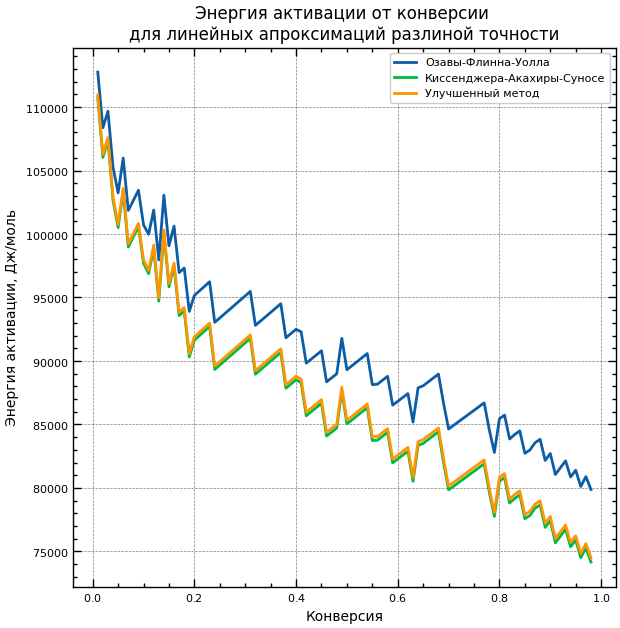

In [177]:
fig, ax = plt.subplots(figsize=(7,7))

# отрисовываем графики для всех трех методов
ax.plot(Ea_df['conversion'], Ea_df['Ea_OFW'], label='Озавы-Флинна-Уолла')
ax.plot(Ea_df['conversion'], Ea_df['Ea_KAS'], label='Киссенджера-Акахиры-Суносе')
ax.plot(Ea_df['conversion'], Ea_df['Ea_improved'], label='Улучшенный метод')

# устанавливаем подписи осей и название графика
ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
ax.set_ylabel('Энергия активации, Дж/моль', fontsize=MEDIUM_SIZE)
ax.set_title('Энергия активации от конверсии \nдля линейных апроксимаций разлиной точности', fontsize=BIG_SIZE)
ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

# добавляем легенду
ax.legend(fontsize=SMALL_SIZE)

plt.show()


$$ Метод~Вязовкина $$ 
Интеграл по температуре $p(x)$ в неизотермическом законе скорости (уравнение 17) является функцией Ea и температуры. Поэтому уравнение 17 можно записать следующим образом:

$$g({\alpha}) = \frac{AEa}{\beta R} I(Ea,T) \tag{25}$$

где $I(Ea, T) = p(x)$. Общее предположение, используемое в методе Вязовкина (или любом другом изоконверсионном методе), состоит в том, что модель реакции не зависит от скорости нагрева (т. е. $g_{\alpha}$ будет одинаковой при любой скорости нагрева). Поэтому для значения превращения $(\alpha)$ можно определить следующее отношение, если применяются две скорости нагрева:

$$ g({\alpha}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_1R} I(E_{a\alpha},T_{\alpha 1}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_2 R} I(E_{a\alpha},T_{\alpha 2}) \tag{26} $$

где $\beta_1$ - первая скорость нагрева, $\beta_2$ - вторая скорость нагрева, $T_{\alpha 1}$ - температура для определенного значения $\alpha$ при использовании первой скорости нагрева, $T_{\alpha 2}$ - температура при том же значении $\alpha$ при использовании второй скорости нагрева, $E_{a\alpha}$ - энергия активации при этом значении $\alpha$ и $A_{\alpha}$ - частотный фактор при этом значении $\alpha$. Для эксперимента с "n" скоростями нагрева отношение будет следующим:

$$ g({\alpha}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_1 R} I(E_{a\alpha},T_{\alpha 1}) = \frac{A_{\alpha} E_{a\alpha}}{\beta_2 R} I(E_{a\alpha},T_{\alpha 2}) = ... = \frac{E_{a\alpha}}{\beta_n R} I(E_{a\alpha},T_{\alpha n}) \tag{27}$$ 

что сводится к:

$$ \frac{I(E_{a\alpha}, T_{\alpha 1})}{\beta_1} = \frac{I(E_{a\alpha}, T_{\alpha 2})}{\beta_2} = ... = \frac{I(E_{a\alpha}, T_{\alpha n})}{\beta_n} = \sigma \tag{28} $$

где $\sigma$ - константа.

Для двух скоростей нагрева, используя два члена в уравнении 28, мы получаем:

$$ \frac{I(E_{a\alpha},T_{\alpha 1})}{\beta_1} = \frac{I(E_{a\alpha},T_{\alpha 2})}{\beta_2} = \sigma \tag{29} $$

Если обе стороны разделить на правый или левый член, мы получаем либо:

$$ \frac{\beta_2}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 2})} = 1 \tag{30} $$ 

или

$$ \frac{\beta_1}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 1})} = 1 \tag{31} $$

Объединение уравнения 30 и уравнения 31 дает:

$$ \frac{\beta_2}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 2})} + \frac{\beta_1}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 1})} = 2 \tag{32} $$

Для трех скоростей нагрева можно получить аналогичное уравнение, как показано ниже:

$$ \frac{\beta_2}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 2})} + \frac{\beta_3}{\beta_1}\frac{I(E_{a\alpha},T_{\alpha 1})}{I(E_{a\alpha},T_{\alpha 3})} + \frac{\beta_1}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 1})} + \frac{\beta_3}{\beta_2}\frac{I(E_{a\alpha},T_{\alpha 2})}{I(E_{a\alpha},T_{\alpha 3})} + \frac{\beta_1}{\beta_3}\frac{I(E_{a\alpha},T_{\alpha 3})}{I(E_{a\alpha},T_{\alpha 1})} + \frac{\beta_2}{\beta_3}\frac{I(E_{a\alpha},T_{\alpha 3})}{I(E_{a\alpha},T_{\alpha 2})} = 6 \tag{33} $$

Для "n" скоростей нагрева уравнения 32 и 33 можно обобщить как:

$$ \sum_{i=1}^{n} \sum_{j \neq i} \frac{\beta_jI(E_{a\alpha},T_{\alpha i})}{\beta_iI(E_{a\alpha},T_{\alpha j})} = n(n-1) \tag{34} $$

или

$$ n(n-1) \sum_{i=1}^{n} \sum_{j \neq i} \frac{\beta_jI(E_{a\alpha},T_{\alpha i})}{\beta_iI(E_{a\alpha},T_{\alpha j})} = 0 \tag{35} $$

где температурный интеграл:

$$
I(E_\alpha, T_\alpha) = \int_0^{T_a} \exp \left(-\frac{E_\alpha}{RT}\right) dT \tag{35}
$$

Этот интеграл решается численно. Минимизация повторяется для каждого значения $\alpha$, чтобы получить зависимость $Ea$ от $\alpha$. 

Все рассмотренные до сих пор интегральные изоконверсионные уравнения (21–24, 35) основаны на решении температурного интеграла при предположении, что значение $Ea$  остается постоянным на всем интервале интеграции, то есть $Ea$  не зависит от $\alpha$. На практике $Ea$  часто изменяется с $\alpha$. Нарушение предположения о постоянстве $Ea$  вносит систематическую ошибку в значение $Ea$. Ошибка может быть значительной, до 20–30% в случае сильных изменений $Ea$  с $\alpha$. Эта ошибка не возникает в дифференциальном методе и может быть устранена в интегральных методах путем интегрирования по малым сегментам температуры или времени. Такой тип интеграции легко вводится в уравнение (35) путем вычисления температурного интеграла как:

$$
I(E_\alpha, T_\alpha) = \int_{T_a - d\alpha}^{T_a} \exp \left(-\frac{E_\alpha}{RT}\right) dT \tag{36}
$$


In [178]:
# функция под интегралом
def integrand(T, Ea):
    return np.exp(-Ea/(R*T))

# функция для вычисления температурного интеграла
def I(Ea, T, dT):
    integral, _ = integrate.quad(integrand, T - dT, T, args=(Ea,))
    return integral

# Определяем функцию вычисления левой части уравнения Вязовкина с параметрами Ea (энергия активации), 
# dT (шаг изменения температуры при da=0.02) и произвольным числом других аргументов, в которые будем
# передавать попарно скорости нагрева и температуры при заданной конверсии для переданной скор. нагр.
def vyazovkin_lhs(Ea, dT, *args):
    # Проверяем, что количество дополнительных аргументов четное 
    # (так как они представляют собой пары температуры и скорости нагрева)
    assert len(args) % 2 == 0, "Неверное количество аргументов"
    
    # Вычисляем количество пар температура/скорость нагрева
    n = len(args) // 2 

    # Инициализируем переменную для накопления суммы отношений
    sum_ratio = 0
    
    # Перебираем все скорости нагрева
    for i in range(n):
        # Извлекаем температуру и скорость нагрева для текущего значения i        
        beta_i = args[i*2]  # i-тая скорость нагрева
        T_i = args[i*2+1]  # температура для i-той скорости нагрева
        
        # Перебираем все скорости нагрева еще раз
        for j in range(n):
            # Если i не равно j (так как мы не должны сравнивать скорость нагрева с самой собой)
            if j != i:
                # Извлекаем температуру и скорость нагрева для текущего значения j
                beta_j = args[j*2]  # j-тая скорость нагрева
                T_j = args[j*2+1]  # температура для j-той скорости нагрева                
                
                # Вычисляем отношение для текущей пары i и j и добавляем его к накопленной сумме
                sum_ratio += beta_j/beta_i * I(Ea, T_i, dT)/I(Ea, T_j, dT)

    # Вычисляем и возвращаем результат, вычитая накопленную сумму отношений из n*(n-1)
    result = n*(n-1) - sum_ratio 
    return result

def get_b_T_couples_list(conversion, df, heating_rates, da=0.02):
    # Создаем пустые списки, где будут храниться результаты
    results = []
    dT = []
    
    # Проходим по каждой скорости нагрева из списка heating_rates
    for rate in heating_rates:           
                
        temp = closest_conversion_t(rate, conversion, df)
        temp_lower = closest_conversion_t(rate, conversion - da, df)

        # Добавляем скорость нагрева и температуру в результаты
        results.append(int(rate))
        results.append(temp+273.15) # Переводим температуру в Кельвины

        # Добавляем разницу температур в список dT
        dT.append(temp - temp_lower)

    # Возвращаем dT и результаты
    return np.mean(dT), results

In [179]:
# Задаем диапазон конверсии и энергии активации
conversion = np.round(np.arange(0.05, 0.95, 0.01),4)
Ea = np.arange(10000, 150001, 1000)

# Создаем пустой датафрейм для хранения результатов
vyazovkin_df = pd.DataFrame(index=Ea, columns=conversion)

# Для каждого значения энергии активации и конверсии
for E in tqdm(Ea, position=0, leave=True):
    for conv in conversion:
        # Вычисляем среднее значение dT и пары скорости нагрева / температуры
        dT, beta_T_couples = get_b_T_couples_list(conv, reactions_df, heating_rates)
        
        # Вычисляем значение функции vyazovkin_lhs и сохраняем его в датафрейме
        vyazovkin_df.loc[E, conv] = vyazovkin_lhs(E, dT, *beta_T_couples)

for col in vyazovkin_df.columns:
    vyazovkin_df[col] = pd.to_numeric(vyazovkin_df[col], errors='coerce')

  0%|          | 0/141 [00:00<?, ?it/s]

100%|██████████| 141/141 [00:19<00:00,  7.23it/s]


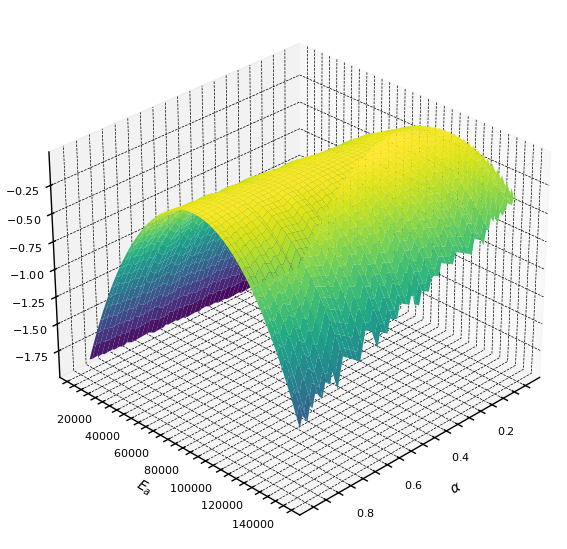

In [180]:
# Создаем объекты для осей x и y
x = vyazovkin_df.columns.values
y = vyazovkin_df.index.values

# Создаем двумерный массив z значений, с использованием значений в DataFrame
z = vyazovkin_df.values

# Создаем сетку координат из x и y
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Отрисовываем поверхность
surf = ax.plot_surface(X, Y, z, cmap='viridis')

# Устанавливаем названия осей с изменяемым размером
ax.set_xlabel(r'$\alpha$', fontsize=MEDIUM_SIZE)
ax.set_ylabel(r'$E_a$', fontsize=MEDIUM_SIZE)
ax.set_zlabel(r'$\sigma$', fontsize=MEDIUM_SIZE)

# Изменяем размер подписей сетки осей
ax.tick_params(axis='x', labelsize=SMALL_SIZE)
ax.tick_params(axis='y', labelsize=SMALL_SIZE)
ax.tick_params(axis='z', labelsize=SMALL_SIZE)

# Поворачиваем фигуру по часовой стрелке на azim градусов
ax.view_init(elev=None, azim=45)

# Сохраняем рисунок
plt.savefig('vyazovkin.png')

# Выводим график
plt.show()


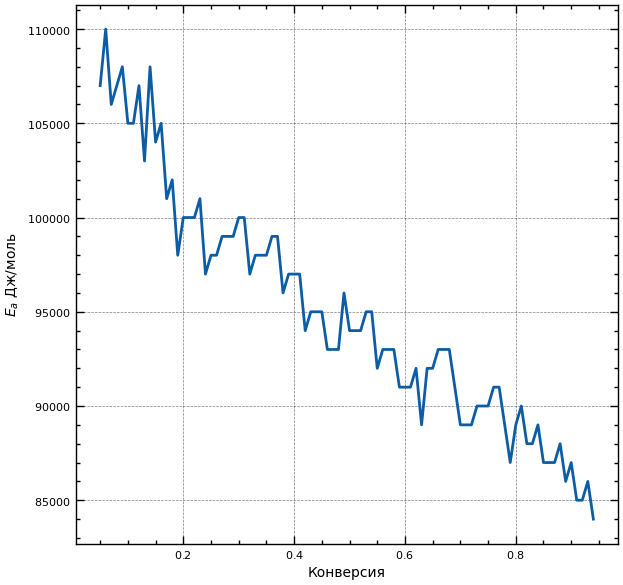

In [181]:
closest_to_zero = vyazovkin_df.abs().min()
vyazovkin_Ea = vyazovkin_df.abs().idxmin()
a = vyazovkin_df.abs().idxmin()

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(vyazovkin_Ea.index, vyazovkin_Ea.values)
ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
ax.set_ylabel(r'$E_a$'+' Дж/моль', fontsize=MEDIUM_SIZE)
#ax.set_title('Ea, расчитанная по методу Вязовкина', fontsize=BIG_SIZE)
ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)
plt.show()

$$ y(\alpha)~и~z(\alpha)~мастер~графики $$
После нахождения $Ea$ безмодельным методом, необходимо убедиться, что она не меняется значительно в зависимости от $\alpha$. Затем приближенно постоянное значение $Ea$ можно заменить средним значением $E_0$, которое подставляется в уравнения (37) или (39). Функция $y(\alpha)$ имеет следующую форму:

$$ y(\alpha) = \frac{d\alpha}{dt}_a \exp\left(\frac{E_0}{RT_\alpha}\right) = Af(\alpha) \tag{37} $$

Уравнение (37) легко получается путем перестановки уравнения дифференциальной формы неизотермического закона скорости реакции (9). Значения $y(\alpha)$ определяются непосредственно из экспериментальных данных путем подстановки $E_0$ в уравнение (37). Затем для каждого значения $\alpha$ необходимо определить экспериментальные значения $(d\alpha/dt)_a$ и $T_\alpha$, связанные с этим $\alpha$, и вставить их в уравнение (37). Полученные в результате экспериментальные значения $y(\alpha)$ строятся в виде функции от $\alpha$ и сравниваются с теоретическими мастер графиками $y(\alpha)$. Подходящая модель определяется как наилучшее соответствие между экспериментальными и теоретическими главными графиками $y(\alpha)$.

Как видно из уравнения (37), форма теоретических мастер графиков $y(\alpha)$ полностью определяется формой функций $f(\alpha)$, поскольку $A$ является постоянной. Однако, поскольку предэкспоненциальный фактор еще не известен, экспериментальные и теоретические графики $y(\alpha)$ должны быть нормализованы. По практическим причинам графики $y(\alpha)$ нормализуются так, чтобы они варьировались от 0 до 1. Тип модели реакции можно распознать по форме экспериментального графика $y(\alpha)$.

Мастер график $z(\alpha)$ получаются путем объединения дифференциальной и интегральной форм моделей реакции. Интеграл температуры в уравнении (15) может быть заменен на различные приближения, $\pi(x)$ следующим образом:

$$g(a) = \frac{AE}{\beta R}\exp(-x)\pi(x)/x \tag{38}$$

где $x = E/RT$. Комбинирование уравнений (9) и (38), за которым следует некоторая перестановка, позволяет ввести функцию $z(\alpha)$ в виде:

$$z(\alpha) = f(\alpha)g(\alpha) = \frac{da}{dt}_a T^2_\alpha \frac{\pi(x)}{\beta T_\alpha} \tag{39}$$

Установлено, что член дроби уравнения (39) оказывает пренебрежимое влияние на форму функции $z(\alpha)$. Таким образом, значения $z(\alpha)$ можно определить для каждого значения $\alpha$, умножив экспериментальные значения $da/dt_a$ и $T^2_a$. Полученные в результате экспериментальные значения $z(\alpha)$ строятся в виде функции от $\alpha$ и сравниваются с теоретическими мастер графиками $z(\alpha)$. Подходящая модель определяется как наилучшее соответствие между экспериментальными и теоретическими мастер графиками $z(\alpha)$. Из серии экспериментальных кинетических кривых, измеренных при различных $\beta$, можно получить серию экспериментальных графиков $z(\alpha)$, которые, однако, должны давать единственную зависимость $z(\alpha)$ от $\alpha$, практически независимую от $\beta$. Теоретические графики $z(\alpha)$ получаются путем построения произведения $f(\alpha)g(\alpha)$ против $\alpha$ для различных моделей реакции.

Следует отметить, что графики $z(\alpha)$ демонстрируют максимум при определенном значении конверсии, $a_p$, который может быть найден из условия:

$$g(\alpha)f'(\alpha) = -1 \tag{40}$$

Значения $a_p$ были рассчитаны для ряда моделей реакции. Значения могут оказать некоторую дополнительную помощь при определении подходящих моделей реакции для экспериментальных данных. Как только модель реакции была идентифицирована, предэкспоненциальный фактор определяется из следующего уравнения:

$$ A =  \frac{-\beta E_0}{R T^2_{max} f'(a_{max})}\exp\left(\frac{E_0}{RT_{max}}\right) \tag{41} $$

В уравнении (41) индекс $max$ обозначает значения, связанные с максимумом дифференциальной кинетической кривой, полученной при данной скорости нагрева.

Проблема с моделью Zero-order (F0/R1): x and y must have same first dimension, but have shapes (500,) and (1,)


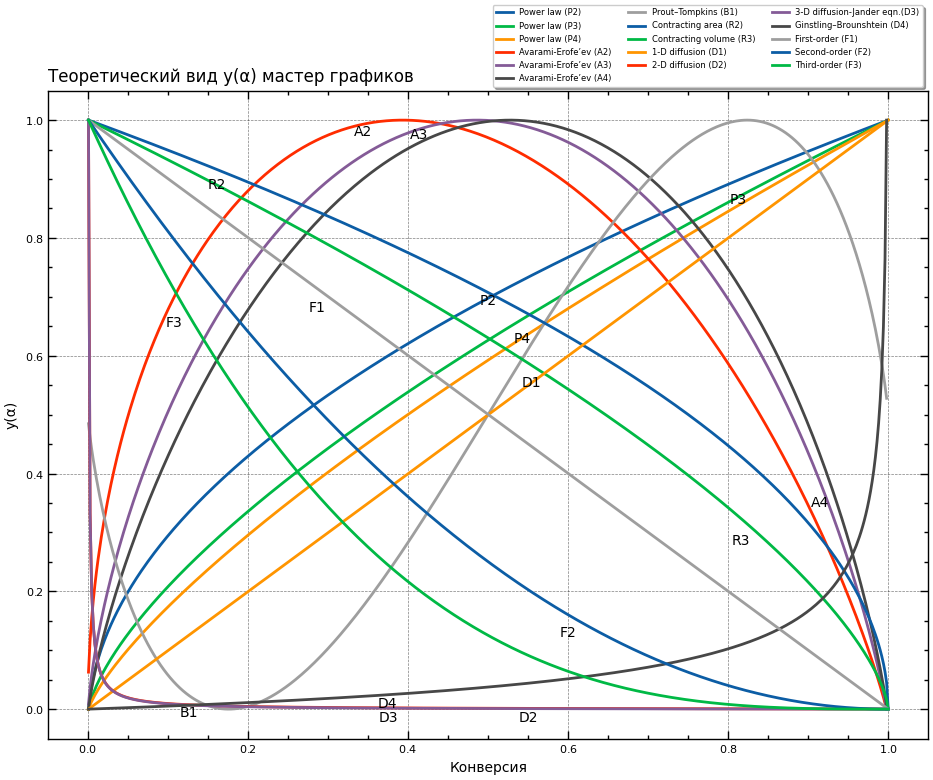

In [182]:
# Создаем значения a от 0 до 1
a = np.linspace(0.001, 1, 500)  # Значения начинаются с 0.001, чтобы избежать деления на ноль

fig, ax = plt.subplots(figsize=(10, 8))

# DataFrame для хранения результата
ya_curves_df = pd.DataFrame()

# Цикл по всем моделям
for index, row in models_df.iterrows():
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            y = eval(row['Differential Form'])  # использование eval для интерпретации выражения как кода Python
            
            # Если максимальное значение бесконечно или np.nan, заменяем его на максимальное не-бесконечное и не-nan значение
            if np.isinf(np.max(y)) or np.isnan(np.max(y)):
                y_max = np.nanmax(y[~np.isinf(y) & ~np.isnan(y)])
            else:
                y_max = np.max(y)
                
            # Если минимальное значение бесконечно или np.nan, заменяем его на минимальное не-бесконечное и не-nan значение
            if np.isinf(np.min(y)) or np.isnan(np.min(y)):
                y_min = np.nanmin(y[~np.isinf(y) & ~np.isnan(y)])
            else:
                y_min = np.min(y)           
            
            y_norm = (y - y_min)/(y_max - y_min)  # нормализация данных
            
            ax.plot(a, y_norm, label=row['Model'])
            
            # Находим сокращенное название модели и добавляем его на график
            short_name = re.search(r'\((.*?)\)', row['Model']).group(1)
            rand_index = np.random.choice(range(len(a)))  # выбираем случайную точку для аннотации
            ax.annotate(short_name, (a[rand_index], y_norm[rand_index]), textcoords="offset points", xytext=(-10,-10), ha='center')

            # Добавляем данные в DataFrame
            temp_df = pd.DataFrame({
                'Conversion': a,
                'Normalized Differential Form': y_norm,
                'Model': row['Model']
            })
            ya_curves_df = pd.concat([ya_curves_df, temp_df])
            
    except Exception as e:
        print(f"Проблема с моделью {row['Model']}: {str(e)}")

# Настройка легенды
ax.legend(loc='best', bbox_to_anchor=(0.5, 1.00), ncol=3, fancybox=True, shadow=True, prop={'size': 6})

ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
ax.set_ylabel('y(α)', fontsize=MEDIUM_SIZE)
ax.set_title('Теоретический вид y(α) мастер графиков', fontsize=BIG_SIZE, loc='left')
ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

plt.tight_layout()
plt.show()


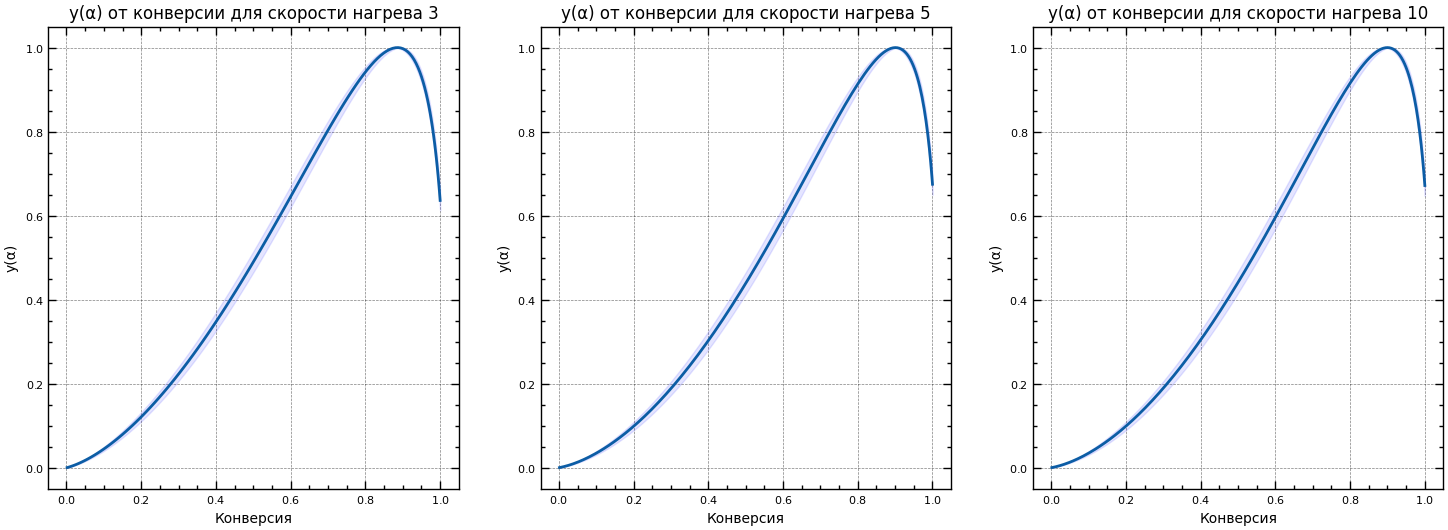

In [183]:
# Получаем описательную статистику для E0, в диапазоне конверсий 0.2 - 0.8
E0_stats = vyazovkin_Ea.iloc[15:-14].describe()
E0_mean = E0_stats['mean']
E0_std = E0_stats['std']

# Создаём пустые словари для хранения нормализованных значений y(α) и его доверительных интервалов
y_alpha = {}
y_alpha_lower = {}
y_alpha_upper = {}

# Перебираем скорости нагрева
for rate in heating_rates:
       
    # Извлекаем отфильтрованные значения конверсии для данной скорости нагрева
    beta = int(rate)
    query = f'conversion_Synthesis_{beta}'
    conversion_rate = reactions_df[query].dropna()
    
    # Переводим индексы температуры из градусов Цельсия в Кельвины
    T_alpha = conversion_rate.index + 273.15
    # Вычисляем скорость изменения конверсии
    d_alpha_dt = conversion_rate.diff()/ conversion_rate.index.to_series().diff()
    
    # Вычисляем экспоненциальные члены в уравнении для нижней и верхней границ доверительных интервалов
    exp_term_lower = np.exp(-(E0_mean - E0_std) / (R * T_alpha))
    exp_term_upper = np.exp(-(E0_mean + E0_std) / (R * T_alpha))
    
    # Вычисляем y(α) для нижней и верхней границ доверительных интервалов и удаляем значения NaN
    y_a_lower = (d_alpha_dt * exp_term_lower).dropna()
    y_a_upper = (d_alpha_dt * exp_term_upper).dropna()

    # Вычисляем экспоненциальный член в уравнении для среднего значения E0
    exp_term = np.exp(-E0_mean / (R * T_alpha))

    # Вычисляем y(α) и удаляем значения NaN
    y_a = (d_alpha_dt * exp_term).dropna()

    # Выполняем нормализацию y(α) и его доверительных интервалов
    y_a_norm = (y_a - y_a.min()) / (y_a.max() - y_a.min())
    y_a_lower_norm = (y_a_lower - y_a_lower.min()) / (y_a_lower.max() - y_a_lower.min())
    y_a_upper_norm = (y_a_upper - y_a_upper.min()) / (y_a_upper.max() - y_a_upper.min())

    # Добавляем нормализованные значения y(α) и его доверительных интервалов в словари
    y_alpha[rate] = y_a_norm
    y_alpha_lower[rate] = y_a_lower_norm
    y_alpha_upper[rate] = y_a_upper_norm    

    y_alpha_lower[rate] = pd.to_numeric(y_alpha_lower[rate], errors='coerce')
    y_alpha_upper[rate] = pd.to_numeric(y_alpha_upper[rate], errors='coerce')
    
# Создаём новую фигуру для графиков
fig, axs = plt.subplots(1, len(heating_rates), figsize=(6*len(heating_rates), 6))

# Перебираем скорости нагрева
for i, rate in enumerate(heating_rates):
    ax = axs[i]
    # Строим график y(α) для данной скорости нагрева
    beta = int(rate)
    query = f'conversion_Synthesis_{beta}'
    conversion_rate = reactions_df[query].dropna()
    ax.plot(conversion_rate.values[1:], y_alpha[rate], label=f'Heating rate: {rate}')
    # Добавляем доверительный интервал на график
    ax.fill_between(conversion_rate.values[1:], y_alpha_lower[rate], y_alpha_upper[rate], color='b', alpha=.1)

    # Устанавливаем название для оси X
    ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    # Устанавливаем название для оси Y
    ax.set_ylabel('y(α)', fontsize=MEDIUM_SIZE)
    # Устанавливаем заголовок графика
    ax.set_title(f'y(α) от конверсии для скорости нагрева {rate}', fontsize=BIG_SIZE)
    # Устанавливаем размер шрифта для делений на осях
    ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

# Отображаем график
plt.show()


In [184]:
# Создаем DataFrame для хранения нормализованных значений кривых
normalized_curves_df = pd.DataFrame()

# Создаем DataFrame для хранения значений среднеквадратического отклонения (MSE)
mse_df = pd.DataFrame()

# Цикл для перебора всех ключей в словаре filtered_conversion_values
for rate in heating_rates:
    beta = int(rate)
    query = f'conversion_Synthesis_{beta}'
    conversion_rate = reactions_df[query].dropna()
    
    # Присваиваем переменной a значения, начиная со второго элемента
    a = conversion_rate.values[1:]

    # Вложенный цикл для перебора всех моделей в DataFrame models_df
    for index, row in models_df.iterrows():
        # Обработка исключений для обнаружения ошибок во время выполнения кода
        try:
            # Игнорирование предупреждений
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                # Использование eval для выполнения выражения Python, хранящегося в столбце 'Differential Form' как кода
                y = eval(row['Differential Form'])

                # Если максимальное значение y бесконечно или NaN, заменяем его на максимальное не-бесконечное и не-NaN значение
                if np.isinf(np.max(y)) or np.isnan(np.max(y)):
                    y_max = np.nanmax(y[~np.isinf(y) & ~np.isnan(y)])
                else:
                    y_max = np.max(y)

                # Если минимальное значение y бесконечно или NaN, заменяем его на минимальное не-бесконечное и не-NaN значение
                if np.isinf(np.min(y)) or np.isnan(np.min(y)):
                    y_min = np.nanmin(y[~np.isinf(y) & ~np.isnan(y)])
                else:
                    y_min = np.min(y)

                # Нормализация значений y
                y_norm = (y - y_min)/(y_max - y_min)

                # Создаем временный DataFrame и добавляем его в итоговый DataFrame
                temp_df = pd.DataFrame({
                    'conversion': a,
                    'normalized_differential_form': y_norm,
                    'model': row['Model'],
                    'heating_rate': rate,
                })

                # Добавляем временный DataFrame в итоговый DataFrame
                normalized_curves_df = pd.concat([normalized_curves_df, temp_df])

        # Обработка исключений и вывод информации об ошибке
        except Exception as e:
            print(f"Проблема с моделью {row['Model']}: {str(e)}")

# Получаем список уникальных моделей
model_names = models_df['Model'].unique()

# Создаем DataFrame для хранения значений MSE с именами скоростей нагрева как столбцы и моделями как индекс
y_mse_df = pd.DataFrame(columns=heating_rates, index=model_names)

# Создаем DataFrame для хранения значений R2 с именами скоростей нагрева как столбцы и моделями как индекс
y_r2_df = pd.DataFrame(columns=heating_rates, index=model_names)

# Цикл для расчета MSE и R2 каждой модели
for model in model_names:
    for rate in heating_rates:
        # Выбираем подходящие данные из normalized_curves_df
        data = normalized_curves_df[
            (normalized_curves_df['model'] == model)
            &(normalized_curves_df['heating_rate'] == rate)]['normalized_differential_form']

        # Получаем индексы, где значения в data являются конечными
        finite_indices = np.isfinite(data)

        # Используем эти индексы для отбора значений в data и y_alpha
        filtered_data = data[finite_indices]
        filtered_y_alpha = y_alpha[rate].values[finite_indices]

        # Рассчитываем MSE между отфильтрованными значениями
        mse = np.mean((filtered_data - filtered_y_alpha)**2)

        # Сохраняем MSE в DataFrame
        y_mse_df.loc[model, rate] = mse

        # Попытка рассчитать R2 между отфильтрованными значениями
        try:
            r2 = r2_score(filtered_y_alpha, filtered_data)
        except ValueError:
            print(f"Проблема с моделью {model}")
            r2 = np.nan

        # Сохраняем R2 в DataFrame
        y_r2_df.loc[model, rate] = r2

# Выводим DataFrame с MSE и R2
y_mse_df
y_r2_df

Проблема с моделью Zero-order (F0/R1)
Проблема с моделью Zero-order (F0/R1)
Проблема с моделью Zero-order (F0/R1)


,3,5,10
Power law (P2),0.739976,0.706607,0.706337
Power law (P3),0.849767,0.832736,0.832856
Power law (P4),0.882403,0.873038,0.873077
Avarami-Erofe’ev (A2),-1.260041,-1.362795,-1.353719
Avarami-Erofe’ev (A3),-0.729542,-0.844912,-0.835106
Avarami-Erofe’ev (A4),-0.500352,-0.618283,-0.608332
Prout–Tompkins (B1),0.845904,0.83308,0.833963
Contracting area (R2),-2.251916,-2.27737,-2.276264
Contracting volume (R3),-2.443895,-2.450888,-2.449903
1-D diffusion (D1),0.920502,0.932094,0.931485


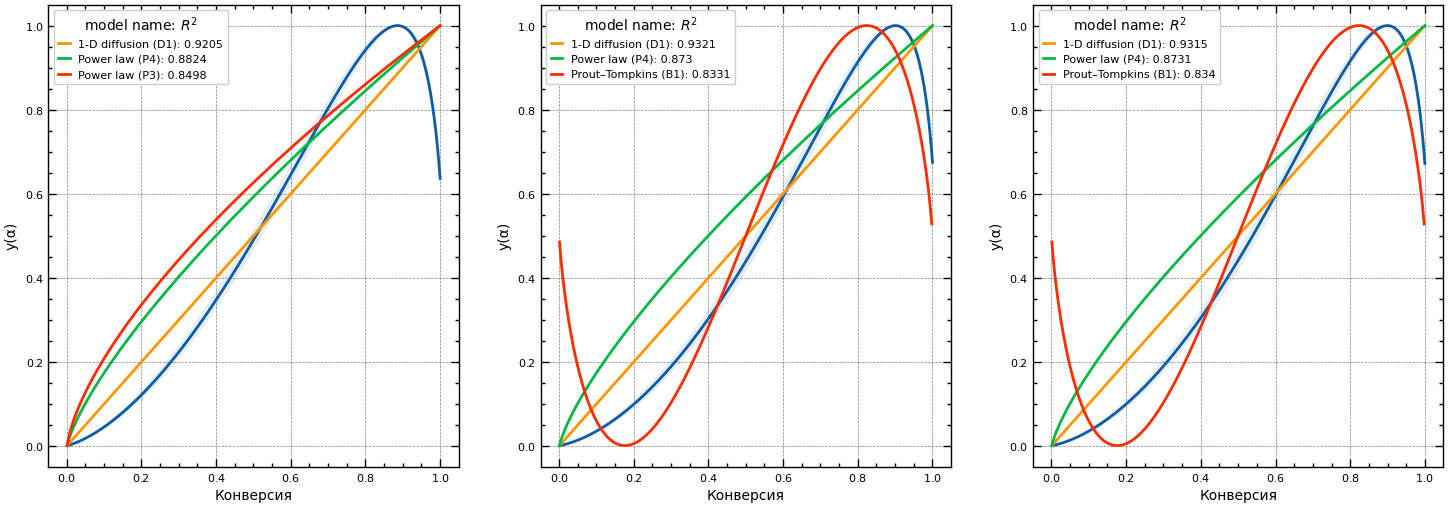

In [185]:
# Количество моделей, которые мы хотим отобразить на графике
TOP_N = 3

# Список цветов для кривых графика
custom_palette = ["#FF9500", "#00B945", "#FF2C00", "#0C5DA5", "#00A8F3", "#B83DBA"]

# Создаём новую фигуру для графиков
fig, axs = plt.subplots(1, len(heating_rates), figsize=(6*len(heating_rates), 6))

# Перебираем скорости нагрева
for i, rate in enumerate(heating_rates):
    beta = int(rate)
    query = f'conversion_Synthesis_{beta}'
    conversion_rate = reactions_df[query].dropna()
    
    ax = axs[i]

    # Строим график y(α) для данной скорости нагрева и добавляем доверительный интервал
    ax.plot(conversion_rate.values[1:], y_alpha[rate], label=f'Heating rate: {rate}')
    ax.fill_between(conversion_rate.values[1:], y_alpha_lower[rate], y_alpha_upper[rate], alpha=.1)

    # Сортируем R**2 для данной скорости нагрева и выбираем топ модели
    top_models = abs(1 - y_r2_df[rate]).sort_values().head(TOP_N).index

    # Создаём пустой список для хранения пар "название модели - R**2"
    r2_values = []

    # Перебираем топ модели
    for j, model in enumerate(top_models):
        # выбираем цвет из палитры по кругу, используя остаток от деления индекса модели на количество цветов в палитре
        # это позволяет повторять цвета, если моделей больше, чем цветов в палитре
        color = custom_palette[j % len(custom_palette)]
        
        # выбираем данные для данной модели и строим график
        model_data = ya_curves_df[ya_curves_df['Model'] == model]
        ax.plot(model_data['Conversion'], model_data['Normalized Differential Form'], color=color)

        # Вычисляем R^2 для модели, округляем до 4 знаков и добавляем в список
        r2_value = round(y_r2_df.loc[model, rate], 4)
        r2_values.append((color, model, r2_value))

    ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
    ax.set_ylabel('y(α)', fontsize=MEDIUM_SIZE)
    ax.tick_params(axis='both', which='both', labelsize=SMALL_SIZE)

    # Создаём DataFrame для таблицы в легенде
    r2_df_for_legend = pd.DataFrame(r2_values, columns=['Color', 'Model', 'R^2'])
    r2_df_for_legend.set_index(['Color', 'Model'], inplace=True)

    # Добавляем легенду с таблицей
    legend_labels = [plt.Line2D([0], [0], color=c, lw=2) for c in r2_df_for_legend.index.get_level_values('Color')]
    ax.legend(
        legend_labels, 
        [f'{m}: {v}' for m, v in zip(r2_df_for_legend.index.get_level_values('Model'), r2_df_for_legend['R^2'])], 
        title=r'model name: $R^2$', title_fontsize=MEDIUM_SIZE, handlelength=1, fontsize=SMALL_SIZE)

# Отображаем график
plt.show()

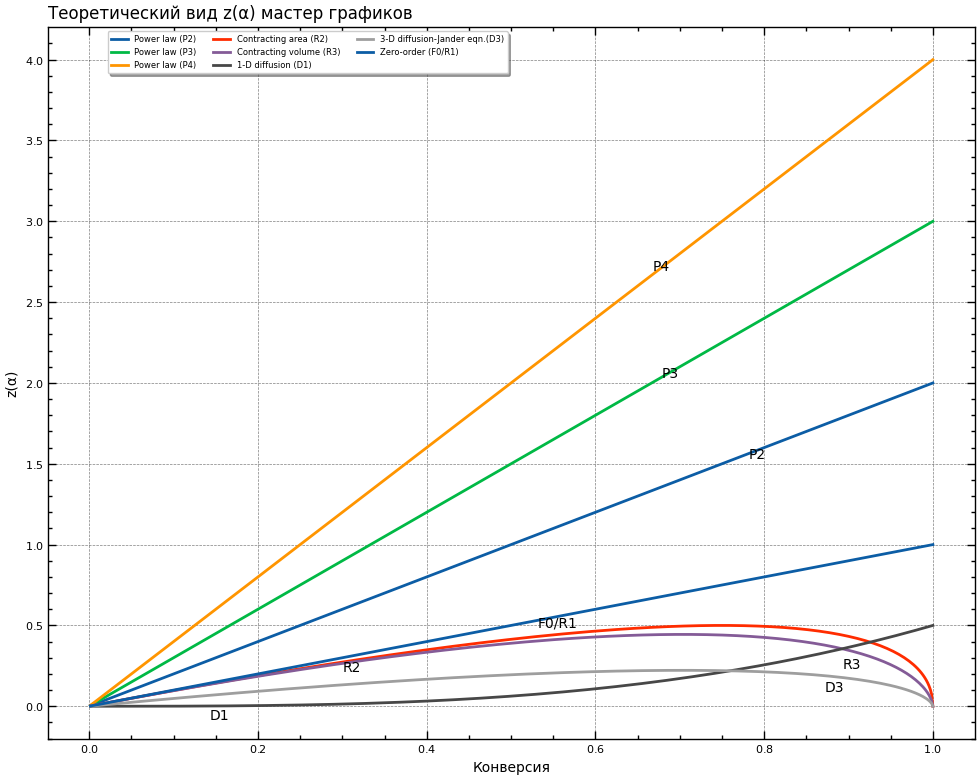

In [186]:
fig, ax = plt.subplots(figsize=(10, 8))

# DataFrame для хранения результата
za_curves_df = pd.DataFrame()

for index, row in models_df.iterrows():
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            g = eval(row['Integral Form'])  # использование eval для интерпретации выражения как кода Python
            y = eval(row['Differential Form'])  # использование eval для интерпретации выражения как кода Python
            
            z = g * y  # вычисление z(a)
            
            # Проверка максимального значения в z
            if np.max(z) <= 12:
                ax.plot(a, z, label=row['Model'])
            
                # Находим сокращенное название модели и добавляем его на график
                short_name = re.search(r'\((.*?)\)', row['Model']).group(1)
                
                # Создаем маску значений x в заданном диапазоне
                mask = np.where((a >= 0.15) & (a <= 0.95))
                
                # выбираем случайную точку из заданного диапазона для аннотации
                rand_index = np.random.choice(mask[0])  
                
                ax.annotate(short_name, (a[rand_index], z[rand_index]), textcoords="offset points", xytext=(-10,-10), ha='center')

                # Добавляем данные в DataFrame
                temp_df = pd.DataFrame({
                    'Conversion': a,
                    'z(a)': z,
                    'Model': row['Model']
                })
                za_curves_df = pd.concat([za_curves_df, temp_df])
            
    except Exception as e:
        print(f"Проблема с моделью {row['Model']}: {str(e)}")

# Настройка легенды
ax.legend(loc='best', bbox_to_anchor=(0.5, 1.00), ncol=3, fancybox=True, shadow=True, prop={'size': 6})

ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
ax.set_ylabel('z(α)', fontsize=MEDIUM_SIZE)
ax.set_title('Теоретический вид z(α) мастер графиков', fontsize=BIG_SIZE, loc='left')
ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

plt.tight_layout()
plt.show()


In [187]:
z_data = pd.DataFrame()  # Создаем пустой DataFrame в начале

for rate in heating_rates:
    # Извлекаем значения конверсии для данной скорости нагрева
    beta = int(rate)
    query = f'conversion_Synthesis_{beta}'
    conversion_rate = reactions_df[query].dropna().values[1:]
    # Переводим индексы температуры
    T_alpha = reactions_df[query].dropna().index[1:]
    # Вычисляем скорость изменения конверсии
    d_alpha_dt = np.gradient(conversion_rate) / np.gradient(T_alpha)

    # Объединяем в один DataFrame
    T_alpha_squared = T_alpha**2
    conversion_rate_series = pd.Series(conversion_rate)
    temp_data = pd.concat([pd.Series(d_alpha_dt), pd.Series(T_alpha_squared), conversion_rate_series], axis=1)
    temp_data.columns = ['d_alpha_dt', 'T_alpha_squared', 'conversion']
    temp_data['rate'] = rate  # добавляем столбец rate
    z_data = pd.concat([z_data, temp_data])  # объединяем с предыдущими DataFrame
    
z_data['z_a'] = z_data['T_alpha_squared'] * z_data['d_alpha_dt']
z_data

,d_alpha_dt,T_alpha_squared,conversion,rate,z_a
0,0.001986,35433.537114,0.001780,3,70.358803
1,0.002049,35793.949627,0.003676,3,73.357937
2,0.002180,36156.189648,0.005694,3,78.820505
3,0.002317,36520.249591,0.007839,3,84.599903
4,0.002459,36886.137082,0.010118,3,90.706589
...,...,...,...,...,...
150,0.001804,121566.375698,0.993766,10,219.349241
151,0.001716,122233.172458,0.995446,10,209.728572
152,0.001630,122901.799937,0.997043,10,200.391006
153,0.001548,123572.244129,0.998560,10,191.336375


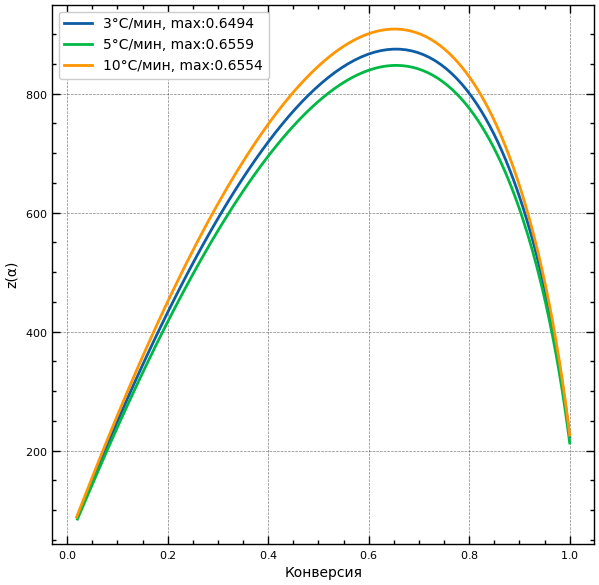

In [188]:
fig, ax = plt.subplots(figsize=(7, 7))

# Проходим по всем значениям скорости нагрева
for rate in heating_rates:
    # Получаем данные для конкретной скорости нагрева
    x = z_data[z_data['rate'] == rate]['conversion']
    y = z_data[z_data['rate'] == rate]['z_a']

    # Определение размера окна для сглаживания
    window_size = 10
    
    # Сглаживаем данные y с помощью скользящего среднего с окном 5
    y_smooth = y.rolling(window=window_size).mean()    

    # Ищем максимальное значение y и соответствующее ему значение x
    y_max = y_smooth.max()
    x_max = np.round(x[y_smooth.idxmax()], 4)
    
    # Строим график для x и сглаженного y
    ax.plot(x, y_smooth, label=rate + '°C/мин, ' + f'max:{x_max}')    

# Устанавливаем названия осей и размер шрифта
ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
ax.set_ylabel('z(α)', fontsize=MEDIUM_SIZE)

# Устанавливаем размер шрифта для меток на осях
ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

# Показываем легенду
ax.legend(prop={'size': 10})

# Отображаем график
plt.show()

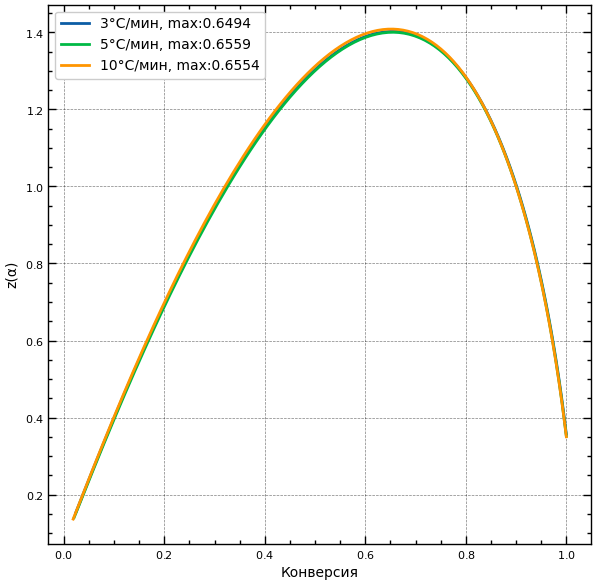

In [189]:
fig, ax = plt.subplots(figsize=(7, 7))

# Проходим по всем значениям скорости нагрева
for rate in heating_rates:
    # Получаем данные для конкретной скорости нагрева
    x = z_data[z_data['rate'] == rate]['conversion']
    y = z_data[z_data['rate'] == rate]['z_a']

    # Определение размера окна для сглаживания
    window_size = 10

    # Сглаживаем данные y с помощью скользящего среднего с окном 5
    y_smooth = y.rolling(window=window_size).mean()

    # Нормализация данных y по y при x близком к 0.5
    closest_to_0_5 = x.iloc[(x - 0.9).abs().argsort()[:1]]
    y_at_x_closest_0_5 = y_smooth[closest_to_0_5.index].values[0]
    y_normalized = y_smooth / y_at_x_closest_0_5

    # Ищем максимальное значение y и соответствующее ему значение x
    y_max = y_normalized.max()
    x_max = np.round(x[y_normalized.idxmax()], 4)

    # Строим график для x и сглаженного y
    ax.plot(x, y_normalized, label=rate + '°C/мин, ' + f'max:{x_max}')

# Устанавливаем названия осей и размер шрифта
ax.set_xlabel('Конверсия', fontsize=MEDIUM_SIZE)
ax.set_ylabel('z(α)', fontsize=MEDIUM_SIZE)

# Устанавливаем размер шрифта для меток на осях
ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

# Показываем легенду
ax.legend(prop={'size': 10})

# Отображаем график
plt.show()


In [190]:


# DataFrame для хранения результата
max_values_df = pd.DataFrame(columns=['Model', 'Numerical Max z(a)', 'Formula Max z(a)'])

for index, row in models_df.iterrows():
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            g = eval(row['Integral Form'])  # использование eval для интерпретации выражения как кода Python
            y = eval(row['Differential Form'])  # использование eval для интерпретации выражения как кода Python
            y_diff = np.gradient(y, a)  # вычисляем численную производную от y
            
            z = g * y  # вычисление z(a)
            
            # Находим численный максимум функции
            numerical_max = np.max(z)
            
            # Находим максимум функции по формуле
            mask = np.where(g*y_diff == -1)
            formula_max = z[mask[0]].max() if len(mask[0]) > 0 else np.nan
            
            # Добавляем данные в DataFrame
            temp_df = pd.DataFrame({
                'Model': [row['Model']],
                'Numerical Max z(a)': [numerical_max],
                'Formula Max z(a)': [formula_max]
            })
            max_values_df = pd.concat([max_values_df, temp_df])
            
    except Exception as e:
        print(f"Проблема с моделью {row['Model']}: {str(e)}")

# Отображаем DataFrame
max_values_df


Проблема с моделью Zero-order (F0/R1): invalid number of arguments


,Model,Numerical Max z(a),Formula Max z(a)
0,Power law (P2),2.000000,NaN
0,Power law (P3),3.000000,NaN
0,Power law (P4),4.000000,NaN
0,Avarami-Erofe’ev (A2),NaN,NaN
0,Avarami-Erofe’ev (A3),NaN,NaN
0,Avarami-Erofe’ev (A4),NaN,NaN
0,Prout–Tompkins (B1),NaN,NaN
0,Contracting area (R2),0.499999,NaN
0,Contracting volume (R3),0.444443,NaN
0,1-D diffusion (D1),0.500000,NaN


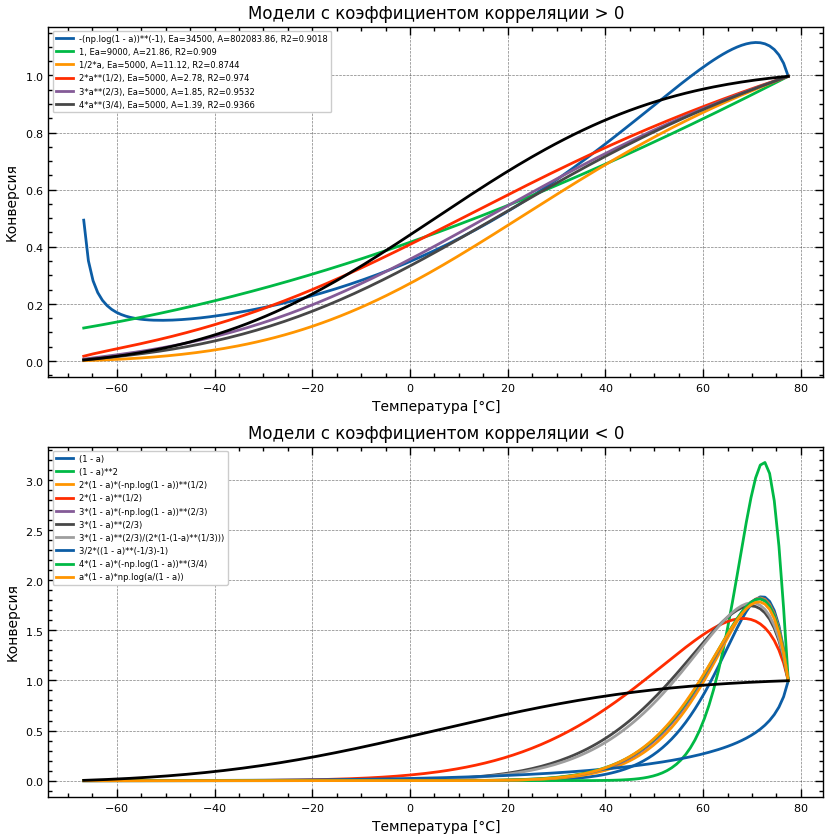

In [191]:
temperature, conversion = get_data(reactions_df, beta)

# Создаем DataFrame, в котором будут храниться результаты
fit_df = pd.DataFrame(columns=['Model', 'Ea', 'A', 'r_sq'])

# Проходим по каждой строке в DataFrame с моделями
for index, row in models_df.iterrows():
    # Извлекаем дифференциальную форму модели
    model = row['Differential Form']
    
    # Определяем функцию, основанную на строке модели
    # Эта функция принимает на вход аргумент a и строку модели, возвращает результат вычисления строки модели
    def fa(a, model):
        return eval(model)

    # Проходим по каждому значению Ea в диапазоне от 5000 до 150000 с шагом 500
    for Ea in range(5000, 340001, 500):
        try:
            # Вычисляем функцию, основанную на модели и преобразуем её с учетом Ea и температуры
            func = fa(conversion[1:-1], model) * np.exp(-Ea / (R * temperature[1:-1]))
            # Вычисляем коэффициент A как отношение последнего элемента конверсии к последнему элементу функции
            A = conversion[1:-1][-1] / func[-1]
            # Производим корректировку функции с помощью коэффициента A
            model_fit = func * A
            # Вычисляем коэффициент детерминации между реальными значениями конверсии и значениями модели
            r_sq = r2_score(conversion[1:-1], model_fit)
    
            # Добавляем результаты в DataFrame
            fit_df = pd.concat([fit_df, pd.DataFrame({'Model': [model], 'Ea': [Ea], 'A': [A], 'r_sq': [r_sq]})])
        except Exception as e:
            # Если возникает ошибка, выводим информацию о ней и прерываем текущий цикл
            print(f"Error occurred with model: {model} and Ea: {Ea}. Error: {e}")
            break  # Если произошла ошибка, прерываем цикл для этой модели и переходим к следующей модели

# Сбросим индекс для fit_df
fit_df_reset = fit_df.reset_index()

# Находим индексы с максимальным значением r_sq для каждой модели
idx = fit_df_reset.groupby(['Model'])['r_sq'].idxmax()

# Создаем новый DataFrame с лучшими результатами для каждой модели
best_fits = fit_df_reset.loc[idx]

# Создаем два подграфика
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Проходим по каждой строке в best_fits
for index, row in best_fits.iterrows():
    # Вычисляем функцию для модели
    func = fa(conversion[1:-1], row['Model']) * np.exp(-row['Ea'] / (R * temperature[1:-1])) * row['A']
    # Если r_sq больше 0, строим модель на первой графической области
    if row['r_sq'] > 0.8:
        ax[0].plot(temperature[1:-1] - 273.15, func, label=f"{row['Model']}, Ea={row['Ea']}, A={np.round(row['A'],2)}, R2={np.round(row['r_sq'],4)}")
    # Если r_sq меньше 0, строим модель на второй графической области
    else:
        if func.max() < 5:
            ax[1].plot(temperature[1:-1] - 273.15, func, label=row['Model'])

# Добавляем легенду и название для каждого графика
ax[0].legend(loc='upper left', prop={'size': 6})
ax[0].set_title('Модели с коэффициентом корреляции > 0', fontsize=BIG_SIZE,)
ax[0].set_xlabel('Температура [°C]', fontsize=MEDIUM_SIZE)
ax[0].set_ylabel('Конверсия', fontsize=MEDIUM_SIZE)
# Устанавливаем размер шрифта для меток на осях
ax[0].tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

ax[1].legend(loc='upper left', prop={'size': 6})
ax[1].set_title('Модели с коэффициентом корреляции < 0', fontsize=BIG_SIZE,)
ax[1].set_xlabel('Температура [°C]', fontsize=MEDIUM_SIZE)
ax[1].set_ylabel('Конверсия', fontsize=MEDIUM_SIZE)
# Устанавливаем размер шрифта для меток на осях
ax[1].tick_params(axis='both', which='major', labelsize=SMALL_SIZE)

# Выводим график конверсии в зависимости от температуры
ax[0].plot(temperature[1:-1] - 273.15, conversion[1:-1], 'k-', label='конверсия')
ax[1].plot(temperature[1:-1] - 273.15, conversion[1:-1], 'k-', label='конверсия')

# Показываем график
plt.show()

In [192]:
# warnings.filterwarnings('ignore')

# rate = '3'
# conversion_col = f'conversion_{rate}'
# reactions_col = f'reactions_{rate}'
# mask = df[reactions_col] == 'reaction_0'
# df_masked = df[mask]

# a = df_masked[conversion_col].values
# T = (df_masked[conversion_col].index.to_series() + 273.15).values

# fig, ax = plt.subplots(figsize=(10, 6))

# def integrand(T, a, R, Ea):
#     return np.exp(-Ea/(R*T))

# def g(a, A, beta, T, Ea, R):
#     integral, error = quad(integrand, 0, T, args=(a, R, Ea))
#     return integral #A/beta *

# # Iterate over all models
# for _model_name in top_20_cr[top_20_cr['beta'] == '3']['Model'].to_list():
#     _int = models_df[models_df['Model'] == _model_name]['Integral Form']
#     g_a = eval(str(*_int.values))

#     name_mask = top_20_cr['Model'] == _model_name
#     rate_mask = top_20_cr['beta'] == rate

#     Ea = top_20_cr[(name_mask & rate_mask)]['Ea'].values
#     A = top_20_cr[(name_mask & rate_mask)]['A'].values
    
#     g_values = []
#     for a_val, T_val in zip(a, T):
#         g_val = g(a_val, A, int(rate), T_val, Ea, R)
#         g_values.append(g_val)

#     # Normalize the g values
#     min_g = min(g_values)
#     max_g = max(g_values)
#     g_values = [(g_val - min_g) / (max_g - min_g) for g_val in g_values]

#     # Draw the plot for this model with a dashed line of thickness 1
#     ax.plot(T, g_values, label=f'Model: {_model_name}', linestyle='dashed', linewidth=1)

# # Add the a versus T dependency with a line of thickness 1.5
# ax.plot(T, a, label='a(T)', linewidth=1.5, color='red')

# # Set the labels for the axes and the font size
# ax.set_xlabel('T', fontsize=MEDIUM_SIZE)
# ax.set_ylabel('Normalized g(a)', fontsize=MEDIUM_SIZE)

# # Показываем легенду
# ax.legend(prop={'size': 10})

# top_20_cr[rate_mask]


In [193]:
models_df

,Model,Differential Form,Integral Form
0,Power law (P2),2*a**(1/2),a**(1/2)
1,Power law (P3),3*a**(2/3),a**(1/3)
2,Power law (P4),4*a**(3/4),a**(1/4)
3,Avarami-Erofe’ev (A2),2*(1 - a)*(-np.log(1 - a))**(1/2),(-np.log(1 - a))**(1/2)
4,Avarami-Erofe’ev (A3),3*(1 - a)*(-np.log(1 - a))**(2/3),(-np.log(1 - a))**(1/3)
5,Avarami-Erofe’ev (A4),4*(1 - a)*(-np.log(1 - a))**(3/4),(-np.log(1 - a))**(1/4)
6,Prout–Tompkins (B1),a*(1 - a)*np.log(a/(1 - a)),np.log(a/(1 - a))
7,Contracting area (R2),2*(1 - a)**(1/2),1-(1 - a)**(1/2)
8,Contracting volume (R3),3*(1 - a)**(2/3),1-(1 - a)**(1/3)
9,1-D diffusion (D1),1/2*a,a**2
